# Primera Parte: Análisis Cuantitativo

## 1.1	Primer examen preliminar del dataset.  ¿En qué formato está el dataset y qué tiene que ver este formato con Big Data? ¿Qué parámetros hay en el dataset? ¿Cuál es su significado? ¿Existen valores aparentemente incorrectos?

### Instalar los paquetes necesarios, ejecutar solo al principio.

In [138]:
# 📦 Instalar paquetes necesarios
%pip install pandas numpy pyarrow matplotlib seaborn plotly nbformat scipy scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importar librerías

In [139]:
# 📦 Imports principales para análisis de datos y visualización

# Carga y manipulación de datos
import pandas as pd       # type: ignore # Manipulación y análisis de datos tabulares
import numpy as np        # type: ignore # Operaciones numéricas (opcional, pero útil)

# Lectura de archivos Parquet
import pyarrow.parquet as pq  # type: ignore # Backend recomendado para parquet (alternativa: fastparquet)

# Visualización básica y exploratoria
import matplotlib.pyplot as plt      # type: ignore # Visualizaciones estándar (histogramas, scatter, etc.)
import seaborn as sns                # type: ignore # Visualización estadística avanzada (heatmaps, countplots)

# Visualización avanzada 
import plotly.express as px         # type: ignore # Visualizaciones interactivas (incl. Sankey, mapas, etc.)
import plotly.graph_objects as go # type: ignore # Gráficos más complejos y personalizados

# Configuración general de visualizaciones
plt.style.use('seaborn-v0_8')        # Estilo visual estándar
# %matplotlib inline                   # Para visualizar directamente en el notebook

# Para calcular el z-score de las columnas numéricas
from scipy.stats import zscore # type: ignore

# Para manejar rutas de archivos y directorios
import os

# linear models para regresión
from sklearn.linear_model import RANSACRegressor, LinearRegression # type: ignore



### Carga los nombres de zona desde taxi_zone_lookup.csv en zona_nombres

In [140]:
def get_zona_nombres():
    """
    Devuelve un diccionario {LocationID: Zone} con los nombres de zona de NYC.
    1. Si el archivo local 'datasets/taxi_zone_lookup.csv' existe, lo carga desde ahí.
    2. Si no existe, lo descarga de la URL y lo guarda localmente para futuras ejecuciones.
    """
    local_path = "datasets/taxi_zone_lookup.csv"
    url_lookup = "https://raw.githubusercontent.com/renerubio/NYC-TAXI/refs/heads/main/taxi_zone_lookup.csv"

    if os.path.exists(local_path):
        taxi_zones = pd.read_csv(local_path)
        print("Cargado desde archivo local.")
    else:
        taxi_zones = pd.read_csv(url_lookup)
        print("Cargado desde URL.")
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        taxi_zones.to_csv(local_path, index=False)
        print(f"Guardado en {local_path}.")

    return taxi_zones.set_index("LocationID")["Zone"].to_dict()

# Cargar diccionario
zona_nombres = get_zona_nombres()


Cargado desde archivo local.


### Importar y cargar ficheros parquet

In [141]:
# Función reutilizable para cargar Parquet desde local o URL
def cargar_parquet_local_o_url(local_path: str, url: str) -> pd.DataFrame:
    import os
    import pandas as pd

    if os.path.exists(local_path):
        print(f"✅ Cargado desde archivo local: {local_path}")
    else:
        print(f"🌐 Descargando desde URL: {url}")
        df = pd.read_parquet(url, engine="pyarrow")
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        df.to_parquet(local_path, engine="pyarrow", index=False)
        print(f"💾 Guardado en {local_path}")
        return df

    return pd.read_parquet(local_path, engine="pyarrow")

# Ruta base de trip-data
data_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/"

# Diccionario de datasets y sus rutas
datasets = {
    "yellow_df_2025_02": ("datasets/yellow_tripdata_2025-02.parquet", data_path + "yellow_tripdata_2025-02.parquet"),
    "green_df_2025_02":  ("datasets/green_tripdata_2025-02.parquet",  data_path + "green_tripdata_2025-02.parquet"),
    "fhv_df_2025_02":    ("datasets/fhv_tripdata_2025-02.parquet",    data_path + "fhv_tripdata_2025-02.parquet"),
    "fhvhv_df_2025_02":  ("datasets/fhvhv_tripdata_2025-02.parquet",  data_path + "fhvhv_tripdata_2025-02.parquet"),
    "yellow_df_2024_12": ("datasets/yellow_tripdata_2024-12.parquet", data_path + "yellow_tripdata_2024-12.parquet"),
    "green_df_2024_12":  ("datasets/green_tripdata_2024-12.parquet",  data_path + "green_tripdata_2024-12.parquet"),
    "fhv_df_2024_12":    ("datasets/fhv_tripdata_2024-12.parquet",    data_path + "fhv_tripdata_2024-12.parquet"),
    "fhvhv_df_2024_12":  ("datasets/fhvhv_tripdata_2024-12.parquet",  data_path + "fhvhv_tripdata_2024-12.parquet"),
    "yellow_df_2009_02": ("datasets/yellow_tripdata_2009-02.parquet", data_path + "yellow_tripdata_2009-02.parquet"), # Ejercicio 2.5
}

# Cargar todos los datasets
for nombre, (ruta_local, url_remota) in datasets.items():
    globals()[nombre] = cargar_parquet_local_o_url(ruta_local, url_remota)


✅ Cargado desde archivo local: datasets/yellow_tripdata_2025-02.parquet
✅ Cargado desde archivo local: datasets/green_tripdata_2025-02.parquet
✅ Cargado desde archivo local: datasets/fhv_tripdata_2025-02.parquet
✅ Cargado desde archivo local: datasets/fhvhv_tripdata_2025-02.parquet
✅ Cargado desde archivo local: datasets/yellow_tripdata_2024-12.parquet
✅ Cargado desde archivo local: datasets/green_tripdata_2024-12.parquet
✅ Cargado desde archivo local: datasets/fhv_tripdata_2024-12.parquet
✅ Cargado desde archivo local: datasets/fhvhv_tripdata_2024-12.parquet
✅ Cargado desde archivo local: datasets/yellow_tripdata_2009-02.parquet


### Objeto global con los datasets cargados y listos para usar 

In [142]:
# Definimos todos los datasets con sus nombres
datasets = {
    "yellow_tripdata_2025-02": yellow_df_2025_02, # type: ignore
    "green_tripdata_2025-02": green_df_2025_02, # type: ignore
    "fhv_tripdata_2025-02": fhv_df_2025_02, # type: ignore
    "fhvhv_tripdata_2025-02": fhvhv_df_2025_02, # type: ignore
    "yellow_tripdata_2024-12": yellow_df_2024_12, # type: ignore
    "green_tripdata_2024-12": green_df_2024_12, # type: ignore
    "fhv_tripdata_2024-12": fhv_df_2024_12, # type: ignore
    "fhvhv_tripdata_2024-12": fhvhv_df_2024_12, # type: ignore
    "yellow_tripdata_2009-02": yellow_df_2009_02, # type: ignore // Ejercicio 2.5
}

# Liberar memoria de las variables ya cargadas
del yellow_df_2025_02 # type: ignore
del green_df_2025_02 # type: ignore
del fhv_df_2025_02 # type: ignore
del fhvhv_df_2025_02 # type: ignore
del yellow_df_2024_12 # type: ignore
del green_df_2024_12 # type: ignore
del fhv_df_2024_12 # type: ignore
del fhvhv_df_2024_12 # type: ignore
del yellow_df_2009_02 # type: ignore // Ejercicio 2.5


## Análisis de datos

### Presencia de columnas en cada dataset

In [143]:
# Obtenemos todas las columnas únicas
all_columns = set()
for df in datasets.values():
    all_columns.update(df.columns)

# Calculamos frecuencia de cada columna (en cuántos datasets aparece)
column_freq = {col: sum(col in df.columns for df in datasets.values()) for col in all_columns}

# Ordenamos columnas por frecuencia (mayor a menor) y luego alfabéticamente
sorted_columns = sorted(all_columns, key=lambda x: (-column_freq[x], x))

# Creamos la tabla de presencia
presence_data = []
for name, df in datasets.items():
    presence_data.append([name] + ['Sí' if col in df.columns else 'No' for col in sorted_columns])

# Creamos el DataFrame
presence_df = pd.DataFrame(presence_data, columns=['Dataset'] + sorted_columns)

# Mostramos la tabla
print("Presencia de columnas en cada dataset (ordenadas por frecuencia):")
print(presence_df.to_string(index=False))



Presencia de columnas en cada dataset (ordenadas por frecuencia):
                Dataset DOLocationID PULocationID congestion_surcharge mta_tax RatecodeID VendorID dispatching_base_num extra fare_amount improvement_surcharge passenger_count payment_type pickup_datetime store_and_fwd_flag tip_amount tolls_amount total_amount trip_distance cbd_congestion_fee Affiliated_base_number Airport_fee DOlocationID PUlocationID SR_Flag access_a_ride_flag airport_fee base_passenger_fare bcf driver_pay dropOff_datetime dropoff_datetime ehail_fee hvfhs_license_num lpep_dropoff_datetime lpep_pickup_datetime on_scene_datetime originating_base_num request_datetime sales_tax shared_match_flag shared_request_flag tips tolls tpep_dropoff_datetime tpep_pickup_datetime trip_miles trip_time trip_type wav_match_flag wav_request_flag End_Lat End_Lon Fare_Amt Passenger_Count Payment_Type Rate_Code Start_Lat Start_Lon Tip_Amt Tolls_Amt Total_Amt Trip_Distance Trip_Dropoff_DateTime Trip_Pickup_DateTime store_and_

### Obtener todas las columnas y su frecuencia

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_7236\1512539824.py:34: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



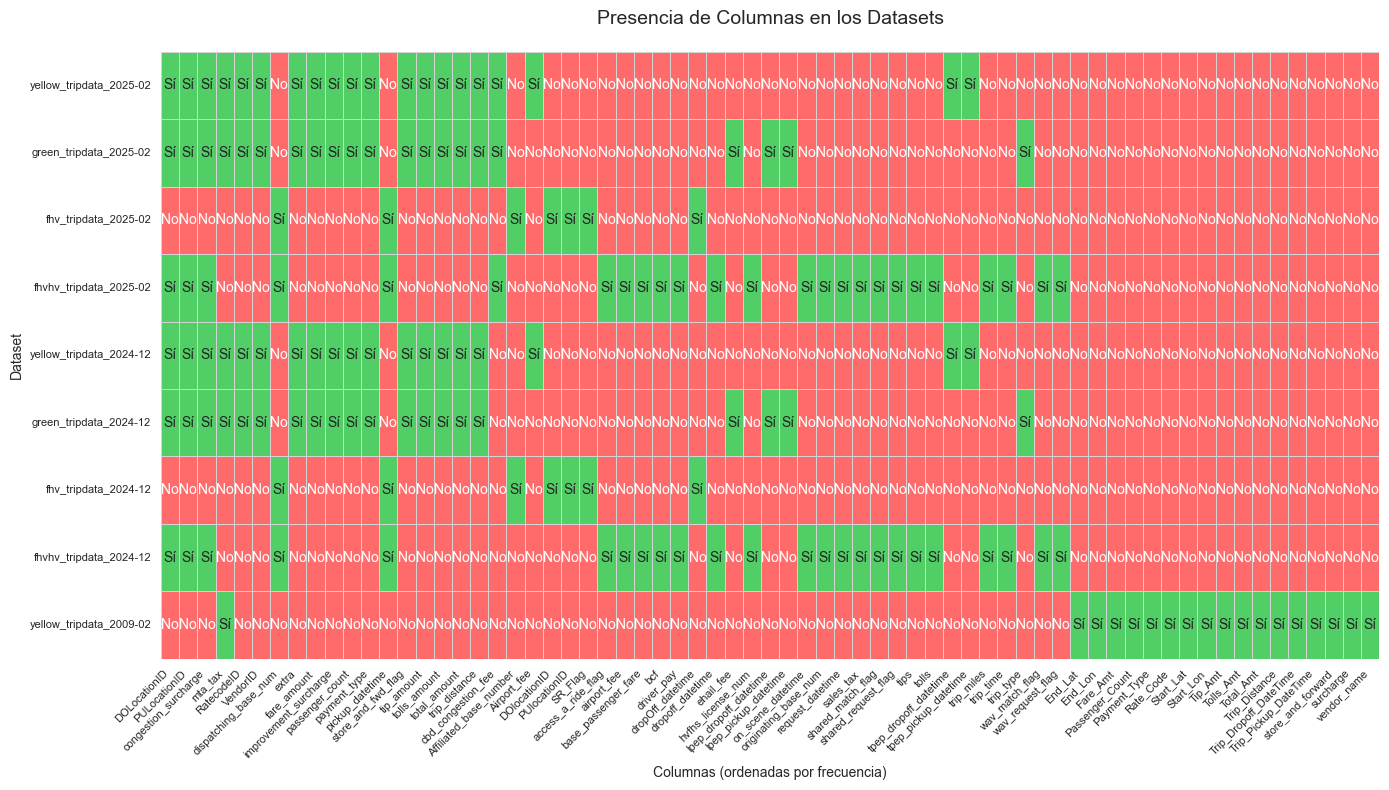

In [144]:

def plot_column_presence_heatmap(datasets):
    """
    Genera un heatmap de presencia de columnas a partir de un diccionario de datasets.

    :param datasets: Diccionario con claves como nombres de dataset y valores como DataFrames
    """

    # 1. Obtener todas las columnas y su frecuencia
    all_columns = set()
    for df in datasets.values():
        all_columns.update(df.columns)
    column_freq = {col: sum(col in df.columns for df in datasets.values()) for col in all_columns}

    # 2. Ordenar columnas por frecuencia (de mayor a menor)
    sorted_columns = sorted(all_columns, key=lambda x: (-column_freq[x], x))

    # 3. Crear matriz de presencia (Sí/No)
    presence_matrix = []
    for name, df in datasets.items():
        presences = [1 if col in df.columns else 0 for col in sorted_columns]
        presences = ["Sí" if p == 1 else "No" for p in presences]
        presence_matrix.append(presences)

    # 4. Crear DataFrame para el heatmap
    heatmap_df = pd.DataFrame(
        presence_matrix,
        index=datasets.keys(),
        columns=sorted_columns
    )

    # 5. Configurar el gráfico
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        heatmap_df.replace({"Sí": 1, "No": 0}),
        cmap=["#FF6B6B", "#51CF66"],
        linewidths=0.5,
        linecolor="lightgray",
        annot=heatmap_df.values,
        fmt="",
        cbar=False
    )

    # 6. Personalizar el gráfico
    plt.title("Presencia de Columnas en los Datasets", fontsize=14, pad=20)
    plt.xlabel("Columnas (ordenadas por frecuencia)", fontsize=10)
    plt.ylabel("Dataset", fontsize=10)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()
plot_column_presence_heatmap(datasets)


## Normalización de características

### Objeto global `column_groups` son grupos de columnas equivalentes para normalización

In [145]:
# Grupos de columnas equivalentes para normalización
column_groups = {
     # Columnas de ubicación
    'PULocationID': ['PUlocationID', 'PULocationID'],
    'DOLocationID': ['DOlocationID', 'DOLocationID'],

    # Columnas temporales
    'pickup_datetime': [
        'tpep_pickup_datetime', 'lpep_pickup_datetime',
        'pickup_datetime', 'Trip_Pickup_DateTime',
        'request_datetime'
    ],
    'dropoff_datetime': [
        'tpep_dropoff_datetime', 'lpep_dropoff_datetime',
        'dropOff_datetime', 'dropoff_datetime', 'on_scene_datetime',
        'Trip_Dropoff_DateTime'
    ],

    # Columnas de distancia
    'trip_distance': [
        'trip_distance',
        'Trip_distance',
        'Trip_Distance',
        'distance',
        'trip_miles'
    ],

    # Columnas de importe total
    'total_amount': ['total_amount', 'Total_Amt'],

    # Columnas de tarifa base
    'fare_amount': ['fare_amount', 'Fare_Amt'],
    
    # Columnas de tarifas
    'airport_fee': ['airport_fee', 'Airport_fee'],
    'extra': ['extra', 'surcharge'],
    
    # Columnas de pago
    'tolls': ['tolls_amount', 'tolls', 'Tolls_Amt'],
    'tips': ['tip_amount', 'tips', 'Tip_Amt'],
    'payment_type': ['payment_type', 'Payment_Type'],

    # Columnas de código de tarifa
    'RatecodeID': ['RatecodeID', 'Rate_Code'],

    # Columnas de ID de proveedor
    'VendorID': ['VendorID', 'vendor_name'],

    # Columnas de número de pasajeros
    'passenger_count': ['passenger_count', 'Passenger_Count'],

    # Columnas de store and forward
    'store_and_fwd_flag': ['store_and_fwd_flag', 'store_and_forward'],

    # Columnas especiales de FHV y FHVHV
    'base_number': [
        'dispatching_base_num', 'Affiliated_base_number',
        'originating_base_num', 'hvfhs_license_num'
    ],
}

### Vamos a normalizar los parámetros para tener uniformidad para los futuros análisis
- Normaliza los nombres de columnas en cada dataset según el diccionario column_groups.
- Añade same_location_flag cuando el punto de recogida y destino son iguales.
- Añade suspicious_location_flag si además la distancia es 0 o el total_amount es muy alto (umbral > 1000$).

In [146]:
# Normalización de nombres de columnas y creación de flags 55 segundos
def normalize_column_names_with_flags(datasets_dict, column_mapping):
    """
    Normaliza los nombres de columnas y agrega:
    - same_location_flag: True si PULocationID == DOLocationID
    - suspicious_location_flag: True si PULocationID == DOLocationID y (trip_distance == 0 o total_amount > umbral)

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
        column_mapping: mapeo de nombres estándar a variantes

    Retorna:
        diccionario con DataFrames normalizados y enriquecidos con flags
    """
    datasets_normalizados = {}
    for nombre, df in datasets_dict.items():
        df = df.copy()

        # 1. Normalización de columnas
        for standard_name, variants in column_mapping.items():
            for variant in variants:
                if variant in df.columns:
                    if standard_name in df.columns and variant != standard_name:
                        df.drop(columns=[variant], inplace=True)
                    else:
                        df.rename(columns={variant: standard_name}, inplace=True)
        df = df.loc[:, ~df.columns.duplicated()]

        # 2. Agregado de flag same_location_flag
        if "PULocationID" in df.columns and "DOLocationID" in df.columns:
            df["same_location_flag"] = df["PULocationID"] == df["DOLocationID"]

            # 3. Agregado de flag suspicious_location_flag
            if "trip_distance" in df.columns and "total_amount" in df.columns:
                df["suspicious_location_flag"] = (
                    (df["same_location_flag"]) &
                    ((df["trip_distance"] == 0) | (df["total_amount"] > 1000))  # umbral arbitrario ajustable
                )
            else:
                df["suspicious_location_flag"] = False
        else:
            df["same_location_flag"] = False
            df["suspicious_location_flag"] = False

        datasets_normalizados[nombre] = df

    return datasets_normalizados

normalized_datasets = normalize_column_names_with_flags(datasets, column_groups)



### Heatmap antes y después de normalizar

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_7236\1512539824.py:34: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



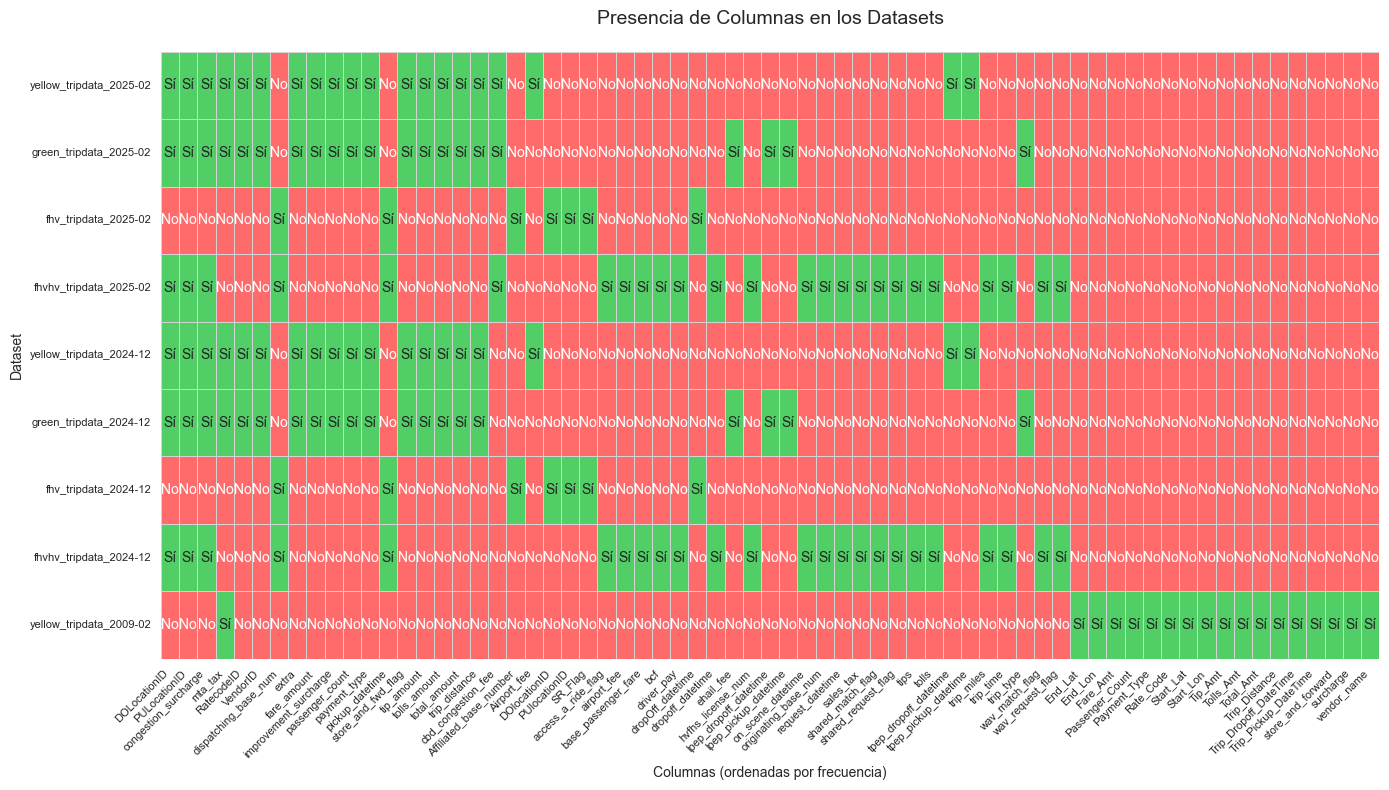

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_7236\1512539824.py:34: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



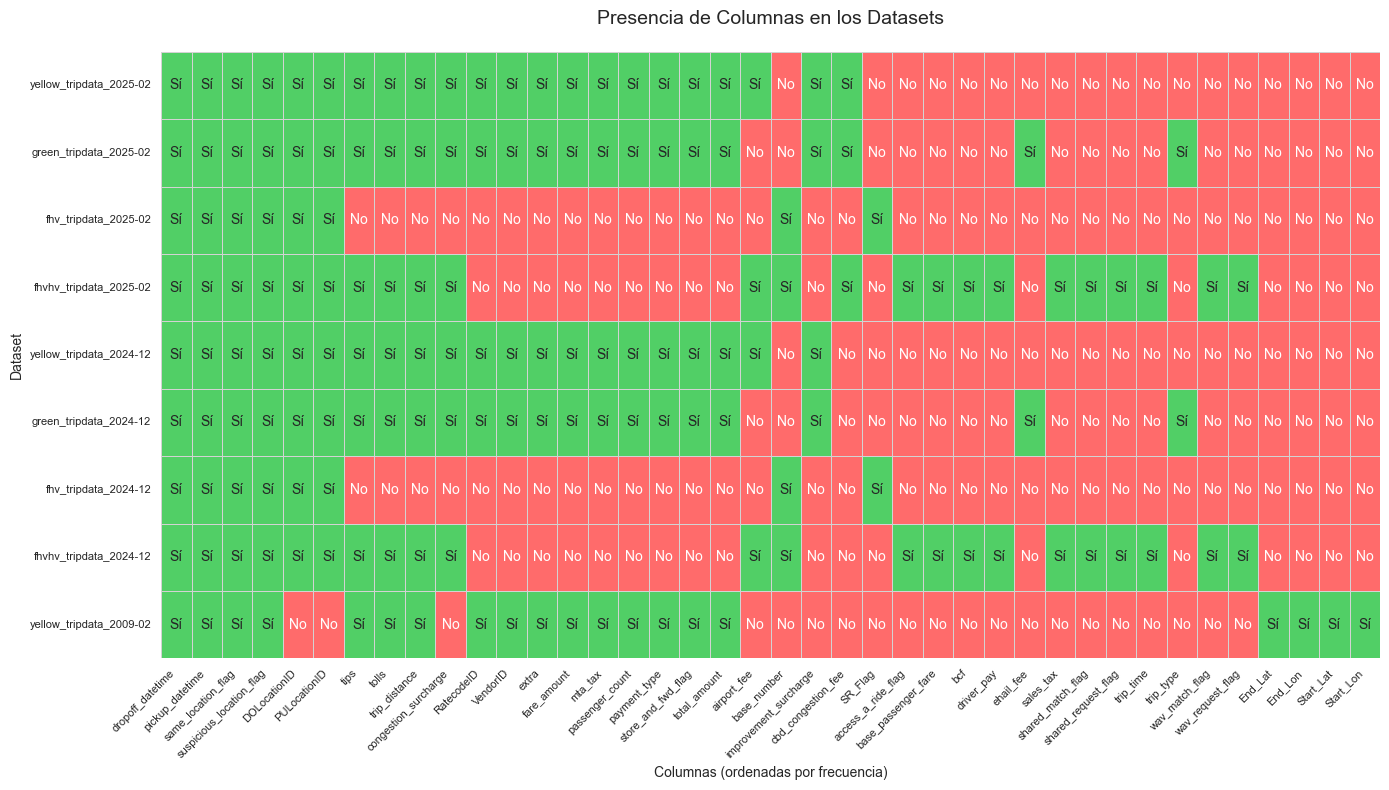

In [147]:
# heatmap de columnas antes de normalizar
plot_column_presence_heatmap(datasets)
# heatmap de columnas después de normalizar
plot_column_presence_heatmap(normalized_datasets)

### Verificación de columnas y valores

In [148]:
# Verificamos la calidad de las columnas ( 1 minuto)
def verificar_calidad_columnas_dict(datasets_dict):
    """
    Verifica la calidad de las columnas para cada DataFrame del diccionario.
    Incluye chequeos de duplicados, nulos, NaN, negativos y tipos de datos.
    """
    for nombre_df, df in datasets_dict.items():
        print(f"\n📋 Verificación de columnas para: {nombre_df}")

        # 1. Columnas duplicadas
        duplicadas = df.columns[df.columns.duplicated()]
        if not duplicadas.empty:
            print(f"🔁 Columnas duplicadas: {duplicadas.tolist()}")
        else:
            print("✅ Sin columnas duplicadas.")

        # 2. Columnas con nulos
        nulos = df.isnull().sum()
        nulos = nulos[nulos > 0]
        if not nulos.empty:
            print("🕳️ Columnas con valores nulos:")
            print(nulos)
        else:
            print("✅ Sin valores nulos.")

        # 3. Columnas con NaN (redundante con isnull, pero mantenido por claridad)
        nans = df.isna().sum()
        nans = nans[nans > 0]
        if not nans.empty:
            print("🧼 Columnas con valores NaN:")
            print(nans)
        else:
            print("✅ Sin valores NaN.")

        # 4. Columnas numéricas con valores negativos
        negativos = df.select_dtypes(include=[np.number]).lt(0).sum()
        negativos = negativos[negativos > 0]
        if not negativos.empty:
            print("🔻 Columnas con valores negativos:")
            print(negativos)
        else:
            print("✅ Sin valores negativos.")

        # 5. Columnas no numéricas
        no_numericas = df.select_dtypes(exclude=[np.number]).nunique()
        if not no_numericas.empty:
            print("🔤 Columnas no numéricas:")
            print(no_numericas)
        else:
            print("✅ Todas las columnas son numéricas (o no hay no numéricas con valores únicos).")

        # 6. Columnas datetime
        columnas_fecha = df.select_dtypes(include=["datetime64[ns]"])
        if not columnas_fecha.empty:
            print(f"📅 Columnas de fecha válidas: {list(columnas_fecha.columns)}")
        else:
            print("❌ No hay columnas de tipo fecha detectadas.")

        # 7. Columnas de texto
        columnas_texto = df.select_dtypes(include=[object]).nunique()
        if not columnas_texto.empty:
            print("✏️ Columnas de texto:")
            print(columnas_texto)
        else:
            print("✅ Sin columnas de texto o con cardinalidad vacía.")


# Ejecutar para "Yellow Feb 2025"
verificar_calidad_columnas_dict(normalized_datasets)
 


📋 Verificación de columnas para: yellow_tripdata_2025-02
✅ Sin columnas duplicadas.
🕳️ Columnas con valores nulos:
passenger_count         806937
RatecodeID              806937
store_and_fwd_flag      806937
congestion_surcharge    806937
airport_fee             806937
dtype: int64
🧼 Columnas con valores NaN:
passenger_count         806937
RatecodeID              806937
store_and_fwd_flag      806937
congestion_surcharge    806937
airport_fee             806937
dtype: int64
🔻 Columnas con valores negativos:
fare_amount              182655
extra                     27786
mta_tax                   53034
tips                        105
tolls                      4138
improvement_surcharge     55016
total_amount              55179
congestion_surcharge      44893
airport_fee                9877
cbd_congestion_fee        37238
dtype: int64
🔤 Columnas no numéricas:
pickup_datetime             1607109
dropoff_datetime            1606589
store_and_fwd_flag                2
same_location_flag  

## Limpieza de Datos (12min)
(Opcional, ejecutar si da error) 
El proceso de limpieza es muy costoso a nivel de recursos, por lo que primero liberaremos memoria para su ejecución.

In [149]:
import gc
del datasets
gc.collect()


109314

In [150]:
## 0. Limpieza de datos glogal 12min
def limpiar_dataset_integrado(datasets_dict, zona_nombres, min_freq=5):
    """
    Optimiza la limpieza de múltiples columnas clave de datasets de taxi.
    - Imputa valores inválidos en: passenger_count, trip_distance, trip_duration_min, total_amount.
    - Añade la columna 'location_valid'.
    - Evita apply por fila y usa map/merge para máxima eficiencia.
    """
    datasets_corregidos = {}

    for nombre, df in datasets_dict.items():
        try:
            print(f"\n🔄 Procesando: {nombre}")
            df = df.copy()

            # Añadir location_valid
            if "PULocationID" in df.columns and "DOLocationID" in df.columns:
                df["location_valid"] = df["PULocationID"].isin(zona_nombres) & df["DOLocationID"].isin(zona_nombres)
                df["key"] = list(zip(df["PULocationID"], df["DOLocationID"]))
            else:
                print(f"⚠️ {nombre}: faltan columnas de localización. Se omite.")
                continue

            # Corrección de passenger_count
            if "passenger_count" in df.columns:
                mask = df["passenger_count"].isnull() | (df["passenger_count"] < 0)
                mediana_global = df.loc[~mask, "passenger_count"].median()
                medianas = df.loc[~mask].groupby("key")["passenger_count"].median()
                df.loc[mask, "passenger_count"] = df.loc[mask, "key"].map(medianas).fillna(mediana_global)

            # Corrección de trip_distance
            if "trip_distance" in df.columns:
                mask = df["trip_distance"].isnull() | (df["trip_distance"] <= 0)
                mediana_global = df.loc[~mask, "trip_distance"].median()

                # Cálculo combinado
                valid_df = df.loc[~mask].copy()
                freq = valid_df.groupby("key").size()
                comunes = freq[freq >= min_freq].index
                medianas = valid_df.groupby("key")["trip_distance"].median()
                df.loc[mask, "trip_distance"] = df.loc[mask, "key"].apply(
                    lambda k: medianas[k] if k in comunes else mediana_global
                )

            # Corrección de trip_duration_min
            if "pickup_datetime" in df.columns and "dropoff_datetime" in df.columns:
                if "trip_duration_min" not in df.columns:
                    df["trip_duration_min"] = (
                        pd.to_datetime(df["dropoff_datetime"]) - pd.to_datetime(df["pickup_datetime"])
                    ).dt.total_seconds() / 60

                mask = df["trip_duration_min"].isnull() | (df["trip_duration_min"] <= 0)
                media_global = df.loc[~mask, "trip_duration_min"].mean()
                medias = df.loc[~mask].groupby("key")["trip_duration_min"].mean()
                df.loc[mask, "trip_duration_min"] = df.loc[mask, "key"].map(medias).fillna(media_global)

            # Corrección de total_amount
            if "total_amount" in df.columns:
                mask = df["total_amount"].isnull() | (df["total_amount"] <= 0)
                media_global = df.loc[~mask, "total_amount"].mean()
                medias = df.loc[~mask].groupby("key")["total_amount"].mean()
                df.loc[mask, "total_amount"] = df.loc[mask, "key"].map(medias).fillna(media_global)

            # Eliminar columna auxiliar
            df.drop(columns=["key"], inplace=True)

            datasets_corregidos[nombre] = df
            print(f"✅ {nombre}: limpieza optimizada completada.")

        except Exception as e:
            print(f"❌ Error procesando {nombre}: {e}")
            continue

    return datasets_corregidos

# Aplicar limpieza a los datasets normalizados
normalized_datasets = limpiar_dataset_integrado(normalized_datasets, zona_nombres)


🔄 Procesando: yellow_tripdata_2025-02
✅ yellow_tripdata_2025-02: limpieza optimizada completada.

🔄 Procesando: green_tripdata_2025-02
✅ green_tripdata_2025-02: limpieza optimizada completada.

🔄 Procesando: fhv_tripdata_2025-02
✅ fhv_tripdata_2025-02: limpieza optimizada completada.

🔄 Procesando: fhvhv_tripdata_2025-02
✅ fhvhv_tripdata_2025-02: limpieza optimizada completada.

🔄 Procesando: yellow_tripdata_2024-12
✅ yellow_tripdata_2024-12: limpieza optimizada completada.

🔄 Procesando: green_tripdata_2024-12
✅ green_tripdata_2024-12: limpieza optimizada completada.

🔄 Procesando: fhv_tripdata_2024-12
✅ fhv_tripdata_2024-12: limpieza optimizada completada.

🔄 Procesando: fhvhv_tripdata_2024-12
✅ fhvhv_tripdata_2024-12: limpieza optimizada completada.

🔄 Procesando: yellow_tripdata_2009-02
⚠️ yellow_tripdata_2009-02: faltan columnas de localización. Se omite.


### Guardar los datasets normalizados y limpios en disco

In [151]:
def guardar_datasets_parquet(datasets_dict, carpeta_destino="datasets_limpios"):
    """
    Guarda los datasets en formato .parquet usando exactamente el nombre del diccionario.
    
    Args:
        datasets_dict (dict): Diccionario con nombre -> DataFrame
        carpeta_destino (str): Nombre de la carpeta donde guardar los ficheros
    """
    os.makedirs(carpeta_destino, exist_ok=True)

    for nombre, df in datasets_dict.items():
        # Mantener el nombre exactamente como está en el diccionario
        ruta = os.path.join(carpeta_destino, f"{nombre}.parquet")
        df.to_parquet(ruta, index=False)
        print(f"✅ Guardado: {ruta}")


# Guardar los datasets normalizados en parquet
guardar_datasets_parquet(normalized_datasets)



✅ Guardado: datasets_limpios\yellow_tripdata_2025-02.parquet
✅ Guardado: datasets_limpios\green_tripdata_2025-02.parquet
✅ Guardado: datasets_limpios\fhv_tripdata_2025-02.parquet
✅ Guardado: datasets_limpios\fhvhv_tripdata_2025-02.parquet
✅ Guardado: datasets_limpios\yellow_tripdata_2024-12.parquet
✅ Guardado: datasets_limpios\green_tripdata_2024-12.parquet
✅ Guardado: datasets_limpios\fhv_tripdata_2024-12.parquet
✅ Guardado: datasets_limpios\fhvhv_tripdata_2024-12.parquet


### Opcional - Cargar todos los datasets *.parquet limpios en un diccionario normalized_datasets
Es opcional si ya los tenemos creados, podríamos cargarlos directamente en vez de pasar todo el proceso de normalización, limpieza, unificación y guardado.

In [152]:
def cargar_datasets_parquet(carpeta="datasets_limpios"):
    """
    Carga los archivos .parquet uno a uno desde la carpeta especificada
    y los guarda en un diccionario con nombres legibles.

    Evita problemas de memoria al no cargar todos simultáneamente.
    """
    datasets = {}
    for archivo in os.listdir(carpeta):
        if archivo.endswith(".parquet"):
            nombre_dataset = archivo.replace(".parquet", "")
            ruta = os.path.join(carpeta, archivo)
            try:
                print(f"📥 Cargando: {nombre_dataset}")
                df = pd.read_parquet(ruta)
                datasets[nombre_dataset] = df
            except Exception as e:
                print(f"⚠️ Error al cargar {nombre_dataset}: {e}")
    return datasets





In [153]:
# Cargar los datasets normalizados desde parquet
normalized_datasets = cargar_datasets_parquet("datasets_limpios")
# Verificar la carga
for name, df in normalized_datasets.items():
    print(f"{name}: {df.shape[0]:,} filas, {df.shape[1]} columnas")

📥 Cargando: fhvhv_tripdata_2024-12
📥 Cargando: fhvhv_tripdata_2025-02
📥 Cargando: fhv_tripdata_2024-12
📥 Cargando: fhv_tripdata_2025-02
📥 Cargando: green_tripdata_2024-12
📥 Cargando: green_tripdata_2025-02
📥 Cargando: yellow_tripdata_2009-02
📥 Cargando: yellow_tripdata_2024-12
📥 Cargando: yellow_tripdata_2025-02
fhvhv_tripdata_2024-12: 21,068,851 filas, 24 columnas
fhvhv_tripdata_2025-02: 19,339,461 filas, 25 columnas
fhv_tripdata_2024-12: 1,913,200 filas, 10 columnas
fhv_tripdata_2025-02: 1,578,722 filas, 10 columnas
green_tripdata_2024-12: 53,994 filas, 24 columnas
green_tripdata_2025-02: 46,621 filas, 25 columnas
yellow_tripdata_2009-02: 13,380,122 filas, 20 columnas
yellow_tripdata_2024-12: 3,668,371 filas, 23 columnas
yellow_tripdata_2025-02: 3,577,543 filas, 24 columnas


### ¿Existen valores aparentemente incorrectos?
Analiza todos los DataFrames en un diccionario (como normalized_datasets). La función evalúa los mismos valores inválidos y genera un resumen por dataset.

In [154]:
# Verificación de calidad de columnas
def analizar_valores_invalidos_dict(datasets_dict):
    """
    Analiza valores inválidos en un diccionario de datasets (DataFrames).

    Devuelve:
        Un DataFrame resumen con el conteo de errores por tipo y dataset.
    """
    resumen = []

    for nombre, df in datasets_dict.items():
        resultados = {}
        print(f"🔍 Analizando: {nombre}")

        # Detectar columnas relevantes
        def get_first_existing(group):
            return next((col for col in group if col in df.columns), None)

        col_passengers = 'passenger_count' if 'passenger_count' in df.columns else None
        col_distance = 'trip_distance' if 'trip_distance' in df.columns else None
        col_total = 'total_amount' if 'total_amount' in df.columns else None
        col_pu = get_first_existing(column_groups['PULocationID'])
        col_do = get_first_existing(column_groups['DOLocationID'])
        col_pickup = get_first_existing(column_groups['pickup_datetime'])
        col_dropoff = get_first_existing(column_groups['dropoff_datetime'])

        # 1. Pasajeros
        if col_passengers:
            resultados['Pasajeros = nulos'] = df[col_passengers].isna().sum()
            resultados['Pasajeros < 0'] = (df[col_passengers] < 0).sum()

        # 2. Distancia
        if col_distance:
            resultados['Distancia = nula'] = df[col_distance].isna().sum()
            resultados['Distancia <= 0'] = (df[col_distance] <= 0).sum()

        # 3 y 4. Duración inválida
        if col_pickup and col_dropoff:
            pickup = pd.to_datetime(df[col_pickup], errors='coerce')
            dropoff = pd.to_datetime(df[col_dropoff], errors='coerce')
            resultados['Pickup/dropoff = nulos'] = pickup.isna().sum() + dropoff.isna().sum()
            resultados['Dropoff < Pickup'] = (dropoff < pickup).sum()
            resultados['Duración = 0 min'] = (dropoff == pickup).sum()

        # 5. Total
        if col_total:
            resultados['Total_amount = nulo'] = df[col_total].isna().sum()
            resultados['Total_amount <= 0'] = (df[col_total] <= 0).sum()

        # 6. Ubicaciones
        if col_pu:
            resultados['PULocationID = nulo'] = df[col_pu].isna().sum()
            resultados['PULocationID fuera de rango'] = df[~df[col_pu].between(1, 263)].shape[0]
        if col_do:
            resultados['DOLocationID = nulo'] = df[col_do].isna().sum()
            resultados['DOLocationID fuera de rango'] = df[~df[col_do].between(1, 263)].shape[0]

        # Agregar los resultados al resumen
        for k, v in resultados.items():
            resumen.append({"Dataset": nombre, "Tipo de error": k, "Nº de registros": v})

    return pd.DataFrame(resumen)

#### Análisis de la calidad de los valores limpiados

In [155]:
# Verificación de calidad de columnas
df_errores = analizar_valores_invalidos_dict(normalized_datasets)
display(df_errores)

# Verificación de calidad de columnas
""" df_original_errores = analizar_valores_invalidos_dict(datasets)
display(df_original_errores) """


🔍 Analizando: fhvhv_tripdata_2024-12
🔍 Analizando: fhvhv_tripdata_2025-02
🔍 Analizando: fhv_tripdata_2024-12
🔍 Analizando: fhv_tripdata_2025-02
🔍 Analizando: green_tripdata_2024-12
🔍 Analizando: green_tripdata_2025-02
🔍 Analizando: yellow_tripdata_2009-02
🔍 Analizando: yellow_tripdata_2024-12
🔍 Analizando: yellow_tripdata_2025-02


,Dataset,Tipo de error,Nº de registros
0,fhvhv_tripdata_2024-12,Distancia = nula,0
1,fhvhv_tripdata_2024-12,Distancia <= 0,0
2,fhvhv_tripdata_2024-12,Pickup/dropoff = nulos,0
3,fhvhv_tripdata_2024-12,Dropoff < Pickup,0
4,fhvhv_tripdata_2024-12,Duración = 0 min,3
...,...,...,...
86,yellow_tripdata_2025-02,Total_amount <= 0,0
87,yellow_tripdata_2025-02,PULocationID = nulo,0
88,yellow_tripdata_2025-02,PULocationID fuera de rango,8635
89,yellow_tripdata_2025-02,DOLocationID = nulo,0


' df_original_errores = analizar_valores_invalidos_dict(datasets)\ndisplay(df_original_errores) '

#### Gráfico combinado para representar de forma clara y visual los outliers en las variables más propensas a errores

In [156]:
def comparar_outliers_multivariables(original_dict, limpio_dict):
    """
    Compara histogramas de distancia, duración y total_amount para datasets originales y limpios.
    Omite datasets sin las columnas requeridas.
    """
    for nombre in original_dict:
        if nombre not in limpio_dict:
            print(f"⚠️ {nombre} no está en el conjunto limpio. Se omite.")
            continue

        df_orig = original_dict[nombre].copy()
        df_limpio = limpio_dict[nombre].copy()

        # Verificar columnas necesarias
        if "trip_distance" not in df_orig.columns or "trip_distance" not in df_limpio.columns:
            print(f"⚠️ {nombre} no tiene 'trip_distance'. Se omite.")
            continue

        if "trip_duration_min" not in df_orig.columns:
            pickup_cols = [c for c in ['tpep_pickup_datetime', 'lpep_pickup_datetime', 'pickup_datetime'] if c in df_orig.columns]
            dropoff_cols = [c for c in ['tpep_dropoff_datetime', 'lpep_dropoff_datetime', 'dropoff_datetime', 'dropOff_datetime'] if c in df_orig.columns]
            if pickup_cols and dropoff_cols:
                df_orig["trip_duration_min"] = (
                    pd.to_datetime(df_orig[dropoff_cols[0]], errors="coerce") -
                    pd.to_datetime(df_orig[pickup_cols[0]], errors="coerce")
                ).dt.total_seconds() / 60

        if "trip_duration_min" not in df_limpio.columns and "trip_duration_min" in df_orig.columns:
            df_limpio["trip_duration_min"] = df_orig["trip_duration_min"]

        if "trip_duration_min" not in df_orig.columns or "trip_duration_min" not in df_limpio.columns:
            print(f"⚠️ {nombre} no tiene 'trip_duration_min'. Se omite.")
            continue

        if "total_amount" not in df_orig.columns or "total_amount" not in df_limpio.columns:
            print(f"⚠️ {nombre} no tiene 'total_amount'. Se omite.")
            continue

        # Filtrado para visualización
        df_orig = df_orig[
            (df_orig["trip_distance"] < 20) &
            (df_orig["trip_duration_min"] < 60) &
            (df_orig["total_amount"] < 100)
        ]
        df_limpio = df_limpio[
            (df_limpio["trip_distance"] < 20) &
            (df_limpio["trip_duration_min"] < 60) &
            (df_limpio["total_amount"] < 100)
        ]

        # Visualización
        fig, axs = plt.subplots(3, 1, figsize=(12, 10))
        fig.suptitle(f"Distribución de trayectos – {nombre}", fontsize=16)

        # Distancia
        sns.histplot(df_orig["trip_distance"], bins=60, color="lightcoral", label="Original", ax=axs[0], alpha=0.6)
        sns.histplot(df_limpio["trip_distance"], bins=60, color="seagreen", label="Limpio", ax=axs[0], alpha=0.6)
        axs[0].set_title("Histograma de distancias (<20 mi)")
        axs[0].legend()

        # Duración
        sns.histplot(df_orig["trip_duration_min"], bins=60, color="lightcoral", label="Original", ax=axs[1], alpha=0.6)
        sns.histplot(df_limpio["trip_duration_min"], bins=60, color="seagreen", label="Limpio", ax=axs[1], alpha=0.6)
        axs[1].set_title("Histograma de duración (<60 min)")
        axs[1].legend()

        # Total amount
        sns.histplot(df_orig["total_amount"], bins=60, color="lightcoral", label="Original", ax=axs[2], alpha=0.6)
        sns.histplot(df_limpio["total_amount"], bins=60, color="seagreen", label="Limpio", ax=axs[2], alpha=0.6)
        axs[2].set_title("Histograma de importe total (<100 $)")
        axs[2].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [157]:
# cargar datasets originales desde parquet local (si hiciera falta, antes se liberó la memoria, eliminando datasets originales)
datasets = cargar_datasets_parquet("datasets")

📥 Cargando: fhvhv_tripdata_2024-12
📥 Cargando: fhvhv_tripdata_2025-02
📥 Cargando: fhv_tripdata_2024-12
📥 Cargando: fhv_tripdata_2025-02
📥 Cargando: green_tripdata_2024-12
📥 Cargando: green_tripdata_2025-02
📥 Cargando: yellow_tripdata_2009-02
📥 Cargando: yellow_tripdata_2024-12
📥 Cargando: yellow_tripdata_2025-02


In [158]:
# mostrar si datasets originales y limpios tienen datos
for name, df in datasets.items():
    print(f"{name}: {df.shape[0]:,} filas, {df.shape[1]} columnas")
for name, df in normalized_datasets.items():
    print(f"{name}: {df.shape[0]:,} filas, {df.shape[1]} columnas")


fhvhv_tripdata_2024-12: 21,068,851 filas, 24 columnas
fhvhv_tripdata_2025-02: 19,339,461 filas, 25 columnas
fhv_tripdata_2024-12: 1,913,200 filas, 7 columnas
fhv_tripdata_2025-02: 1,578,722 filas, 7 columnas
green_tripdata_2024-12: 53,994 filas, 20 columnas
green_tripdata_2025-02: 46,621 filas, 21 columnas
yellow_tripdata_2009-02: 13,380,122 filas, 18 columnas
yellow_tripdata_2024-12: 3,668,371 filas, 19 columnas
yellow_tripdata_2025-02: 3,577,543 filas, 20 columnas
fhvhv_tripdata_2024-12: 21,068,851 filas, 24 columnas
fhvhv_tripdata_2025-02: 19,339,461 filas, 25 columnas
fhv_tripdata_2024-12: 1,913,200 filas, 10 columnas
fhv_tripdata_2025-02: 1,578,722 filas, 10 columnas
green_tripdata_2024-12: 53,994 filas, 24 columnas
green_tripdata_2025-02: 46,621 filas, 25 columnas
yellow_tripdata_2009-02: 13,380,122 filas, 20 columnas
yellow_tripdata_2024-12: 3,668,371 filas, 23 columnas
yellow_tripdata_2025-02: 3,577,543 filas, 24 columnas


⚠️ fhvhv_tripdata_2024-12 no tiene 'trip_distance'. Se omite.
⚠️ fhvhv_tripdata_2025-02 no tiene 'trip_distance'. Se omite.
⚠️ fhv_tripdata_2024-12 no tiene 'trip_distance'. Se omite.
⚠️ fhv_tripdata_2025-02 no tiene 'trip_distance'. Se omite.


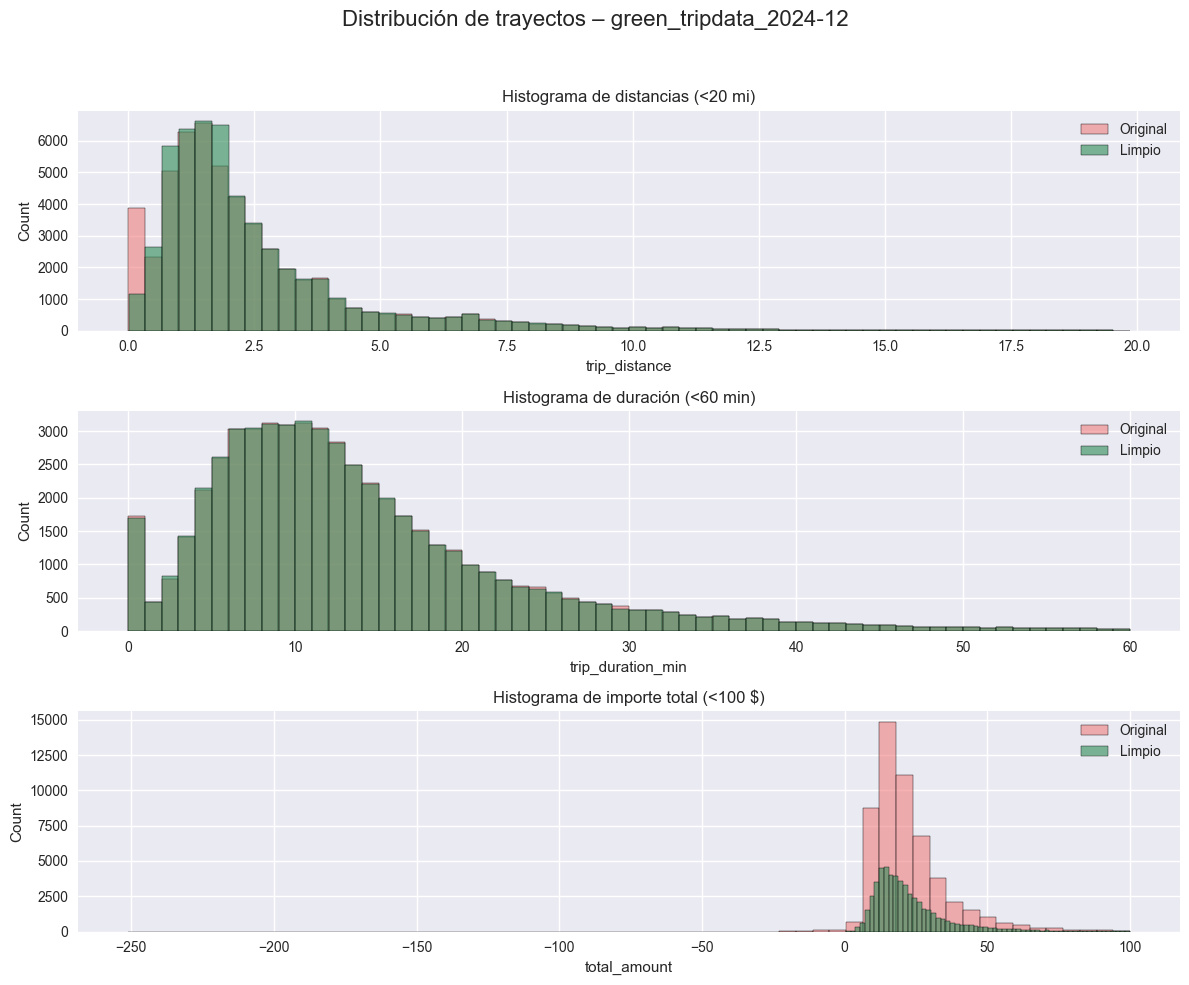

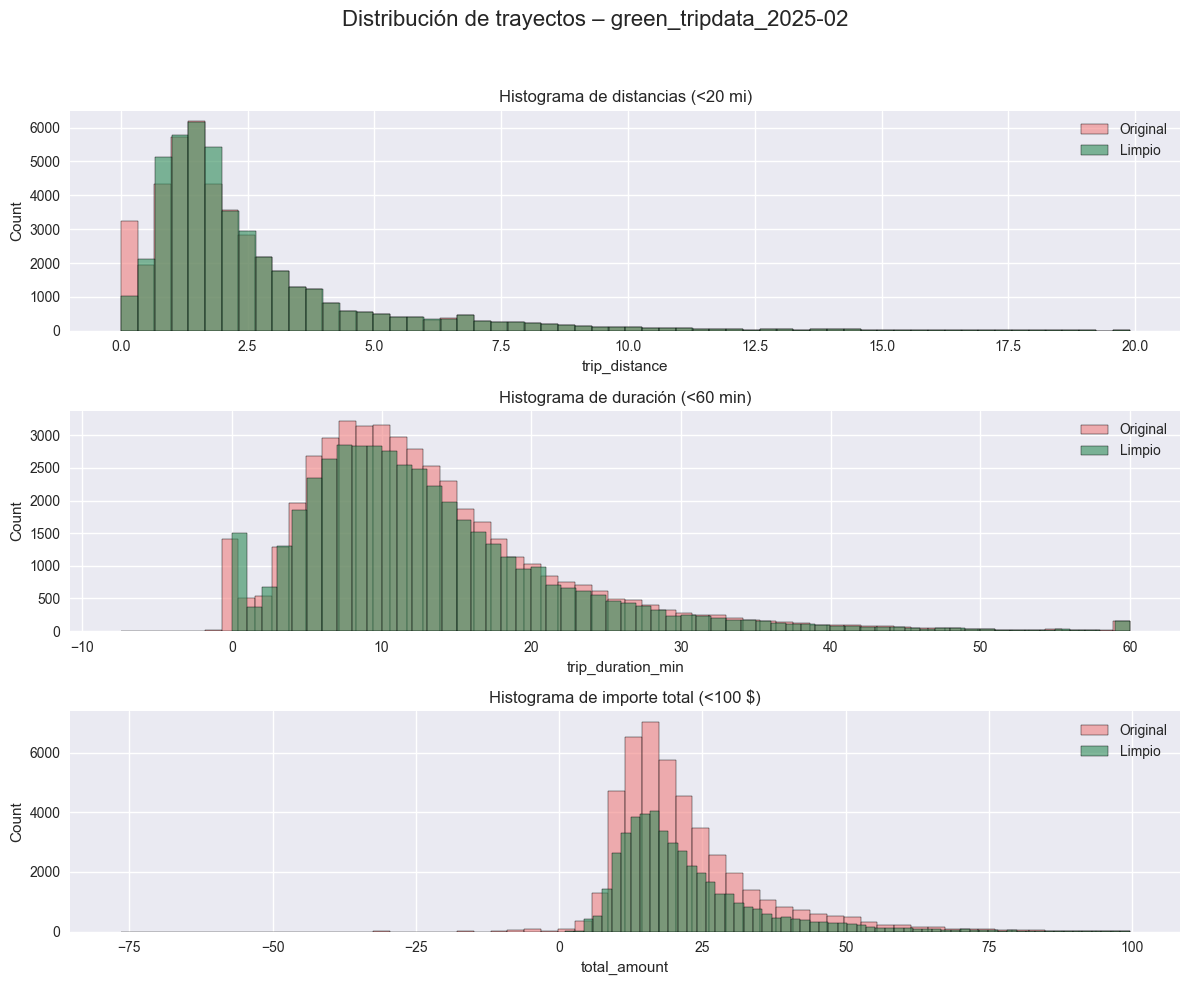

⚠️ yellow_tripdata_2009-02 no tiene 'trip_distance'. Se omite.


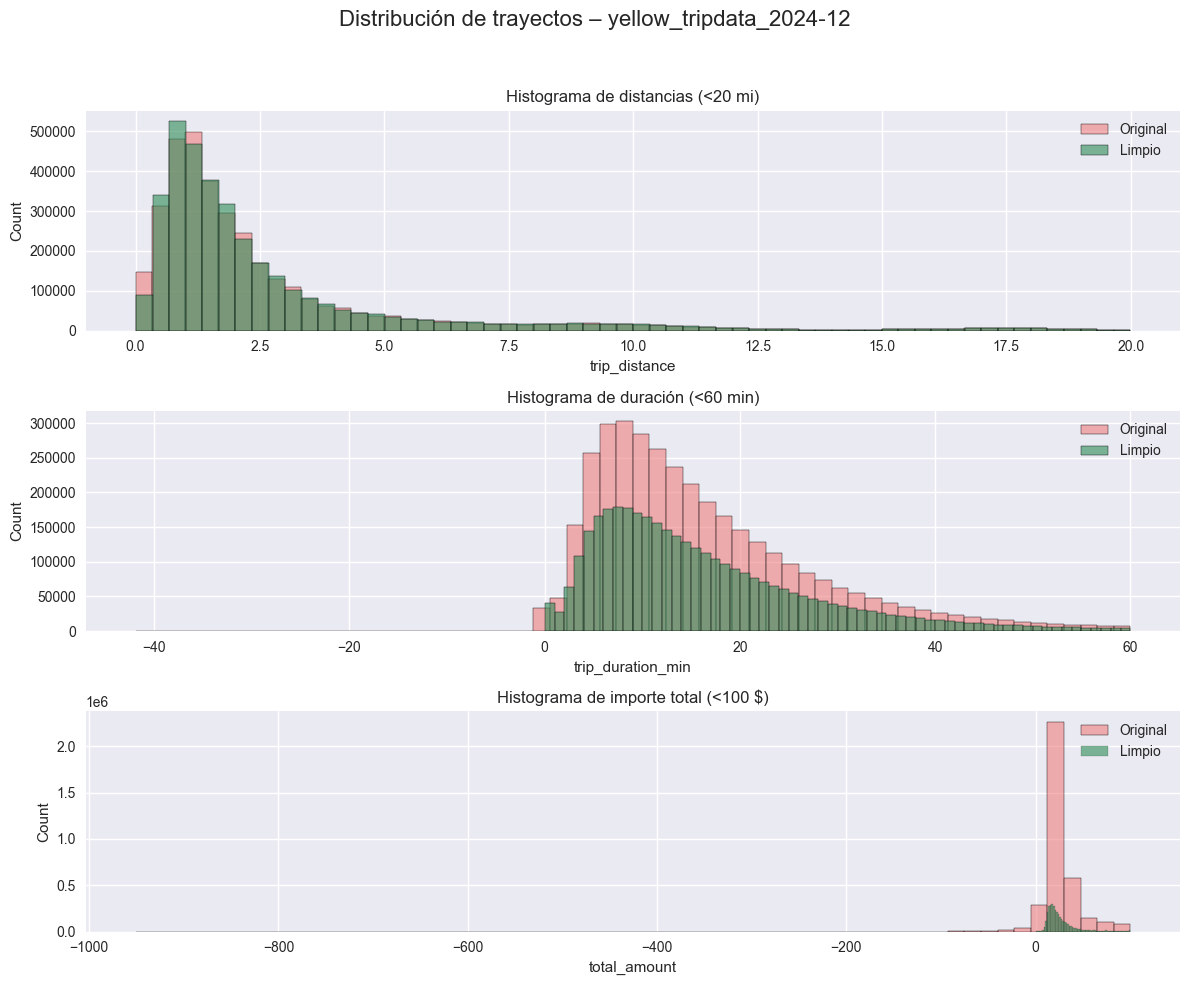

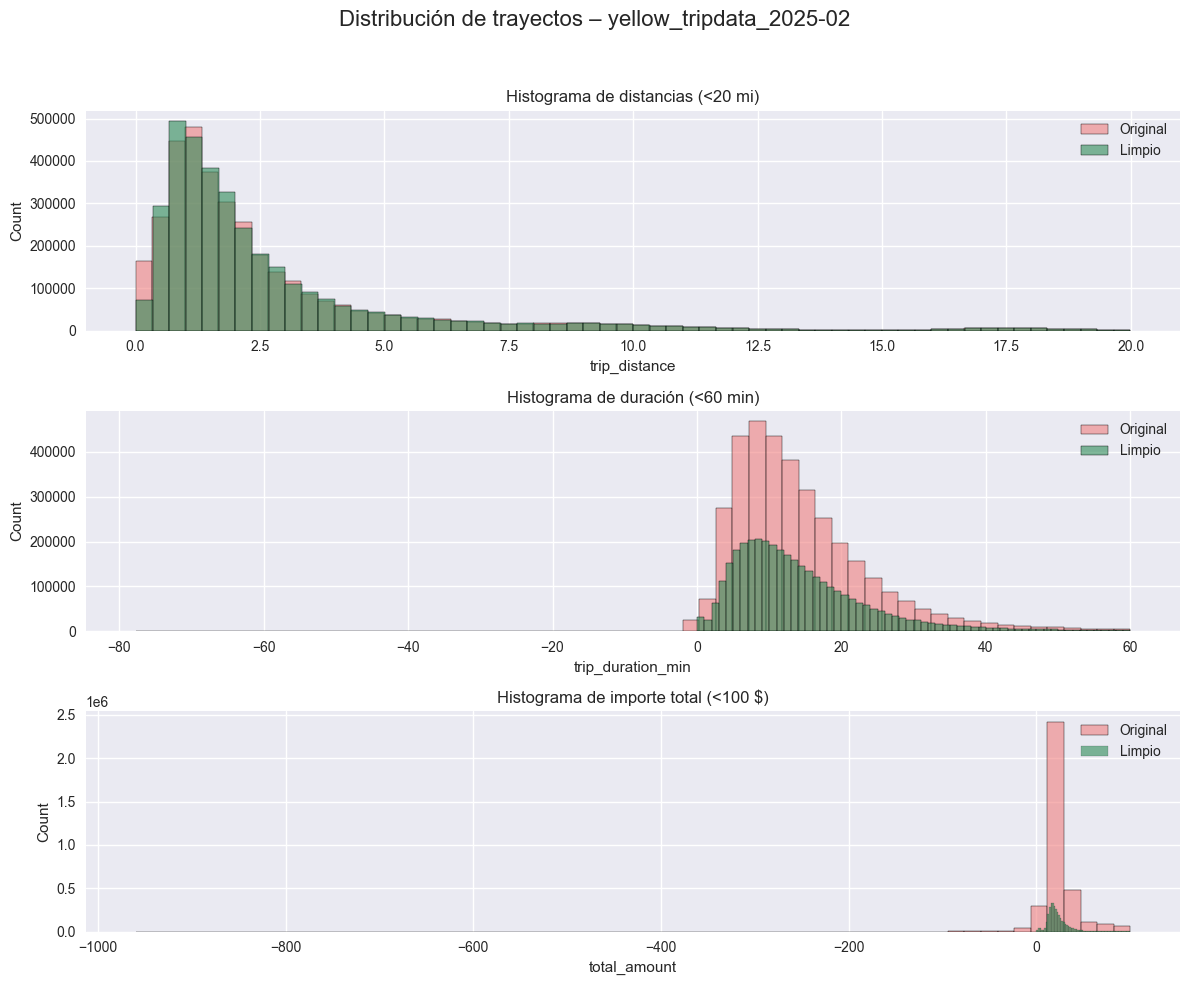

In [159]:
# Muestra de comparación de outliers
comparar_outliers_multivariables(datasets, normalized_datasets)

## 1.2 Empezamos por visualizar el dataset. Haced un plot en el que, para cada dataset, se muestren el número de trayectos entre zonas de forma que en el eje horizontal estén las zonas de recogida y en el eje vertical las zonas de llegada. Extrae conclusiones preliminares. ¿Se aprecian diferencias entre los puntos de los Yellow Cabs y los de los Green Cabs? ¿Se aprecian diferencias entre un mes y otro?

### Visualización de trayectos entre las 20 zonas más activas
- Recorre ambos diccionarios de datasets (originales y limpios).
- Genera un heatmap para cada uno.
- Quita los números dentro de las celdas (annot=False) para que se infieran por escala de color.
- Usa plotly.express.imshow para interactividad: permite ver el valor al pasar el ratón.

In [160]:
def comparar_heatmaps_zonas_activas(original_dict, limpio_dict, top_n=20):
    """
    Compara visualmente los heatmaps de trayectos entre zonas más activas
    entre datasets originales y limpios usando interactividad.

    Parámetros:
    - original_dict: diccionario con datasets originales
    - limpio_dict: diccionario con datasets limpios
    - top_n: número de zonas más activas a considerar
    """
    for nombre in original_dict:
        if nombre not in limpio_dict:
            continue

        df_orig = original_dict[nombre]
        df_limpio = limpio_dict[nombre]

        for df, version in zip([df_orig, df_limpio], ["Original", "Limpio"]):
            # Validar columnas necesarias
            if not {'PULocationID', 'DOLocationID'}.issubset(df.columns):
                print(f"⚠️ {nombre} ({version}): columnas de ubicación no encontradas. Se omite.")
                continue

            # Agrupar trayectos
            zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

            # Top zonas más frecuentes
            top_pu = zonas.groupby('PULocationID')['count'].sum().nlargest(top_n).index
            top_do = zonas.groupby('DOLocationID')['count'].sum().nlargest(top_n).index

            # Filtrar top zonas
            zonas_top = zonas[
                zonas['PULocationID'].isin(top_pu) & zonas['DOLocationID'].isin(top_do)
            ]

            # Pivotear para heatmap
            pivot = zonas_top.pivot(index='DOLocationID', columns='PULocationID', values='count').fillna(0)

            # Plot interactivo con plotly
            fig = px.imshow(
                pivot.values,
                labels=dict(x="PULocationID", y="DOLocationID", color="Nº de Trayectos"),
                x=pivot.columns,
                y=pivot.index,
                color_continuous_scale="YlGnBu",
                title=f"Trayectos entre zonas más activas – {nombre} ({version})"
            )
            fig.update_layout(height=600, width=700)
            fig.show()

comparar_heatmaps_zonas_activas(datasets, normalized_datasets)

⚠️ fhv_tripdata_2024-12 (Original): columnas de ubicación no encontradas. Se omite.


⚠️ fhv_tripdata_2025-02 (Original): columnas de ubicación no encontradas. Se omite.


⚠️ yellow_tripdata_2009-02 (Original): columnas de ubicación no encontradas. Se omite.
⚠️ yellow_tripdata_2009-02 (Limpio): columnas de ubicación no encontradas. Se omite.


In [161]:
# Función para generar un diagrama de Sankey con las 5 zonas más populares

def plot_sankey_top5_dict(datasets_dict, zona_nombres):
    """
    Genera un diagrama de Sankey para cada dataset en el diccionario,
    mostrando los trayectos entre las 5 zonas más frecuentes (origen/destino).

    Parámetros:
    - datasets_dict: diccionario {nombre_dataset: DataFrame}
    - zona_nombres: diccionario {LocationID: Nombre de zona}

    Devuelve:
    - lista de figuras Sankey (una por dataset)
    """
    import plotly.graph_objects as go

    figuras = []

    for nombre, df in datasets_dict.items():
        if "PULocationID" not in df.columns or "DOLocationID" not in df.columns:
            print(f"⚠️ {nombre}: no contiene columnas de ubicación. Se omite.")
            continue

        zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

        # Top 5 zonas más activas combinando origen y destino
        zonas_frecuentes = pd.concat([
            zonas.groupby('PULocationID')['count'].sum(),
            zonas.groupby('DOLocationID')['count'].sum()
        ]).groupby(level=0).sum().nlargest(5).index.tolist()

        zonas_top5 = zonas[
            zonas['PULocationID'].isin(zonas_frecuentes) &
            zonas['DOLocationID'].isin(zonas_frecuentes)
        ]

        if zonas_top5.empty:
            print(f"⚠️ {nombre}: no hay suficientes trayectos entre las 5 zonas más frecuentes.")
            continue

        etiquetas = [f"{z} - {zona_nombres.get(z, 'Desconocido')}" for z in zonas_frecuentes]
        zona_idx = {zona: i for i, zona in enumerate(zonas_frecuentes)}

        source = zonas_top5['PULocationID'].map(zona_idx).tolist()
        target = zonas_top5['DOLocationID'].map(zona_idx).tolist()
        value = zonas_top5['count'].tolist()

        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15, thickness=20,
                line=dict(color="black", width=0.5),
                label=etiquetas
            ),
            link=dict(source=source, target=target, value=value)
        )])

        fig.update_layout(
            title_text=f"Trayectos entre las 5 zonas más populares – {nombre}",
            font_size=12
        )

        fig.show()
        figuras.append(fig)

    return figuras

# Generamos diagramas de Sankey para los datasets de Febrero 2025 y Diciembre 2024 limpios
# Asumiendo que zona_nombres ya está cargado
plot_sankey_top5_dict(normalized_datasets, zona_nombres)

⚠️ yellow_tripdata_2009-02: no contiene columnas de ubicación. Se omite.


[Figure({
     'data': [{'link': {'source': [3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 1,
                                   1, 1, 1, 1, 0, 0, 0, 0],
                        'target': [3, 4, 2, 1, 0, 3, 4, 2, 1, 0, 3, 4, 2, 1, 0, 3,
                                   4, 2, 1, 0, 3, 2, 1, 0],
                        'value': [33297, 855, 7319, 4488, 2226, 1828, 7585, 5776,
                                  6797, 11167, 4327, 3556, 8350, 3477, 65283, 3641,
                                  5836, 4378, 1123, 46258, 1, 19, 7, 257]},
               'node': {'label': [265 - Outside of NYC, 138 - LaGuardia Airport,
                                  132 - JFK Airport, 61 - Crown Heights North, 79 -
                                  East Village],
                        'line': {'color': 'black', 'width': 0.5},
                        'pad': 15,
                        'thickness': 20},
               'type': 'sankey'}],
     'layout': {'font': {'size': 12},
                'template': '...

## 1.4	Mejora la visualización anterior con un heat map. Ayúdate de los Zone Map…

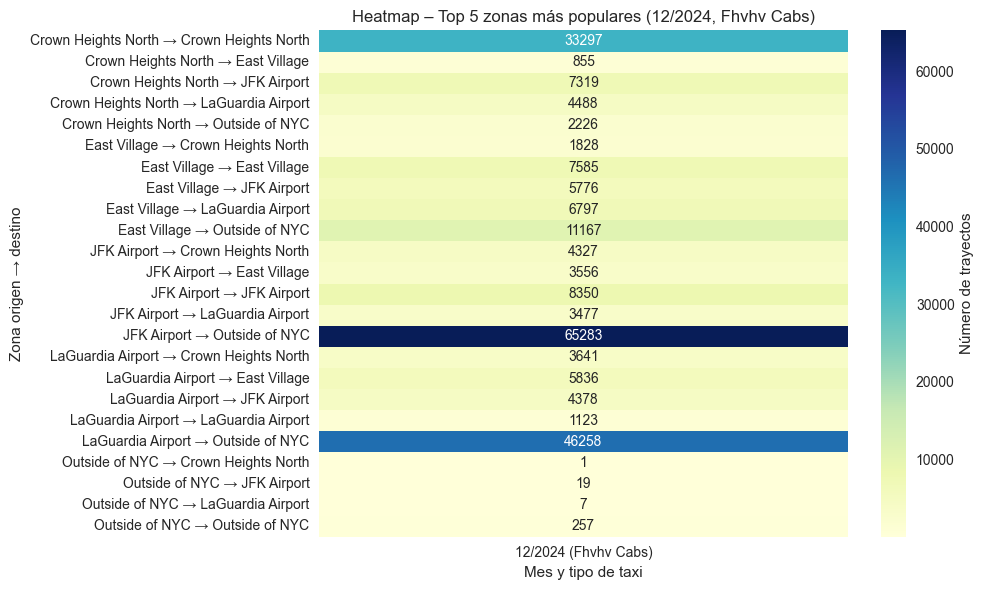

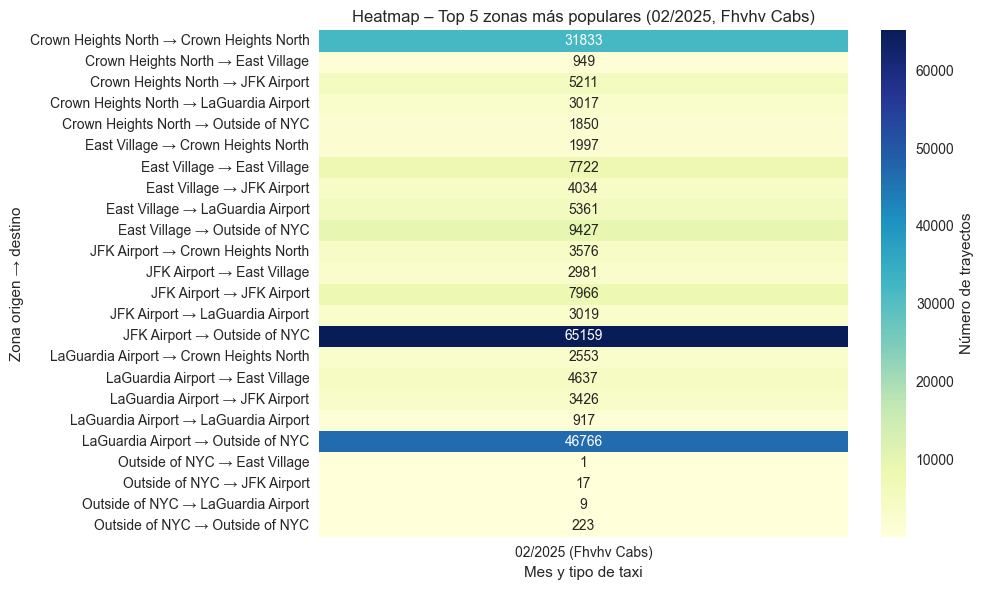

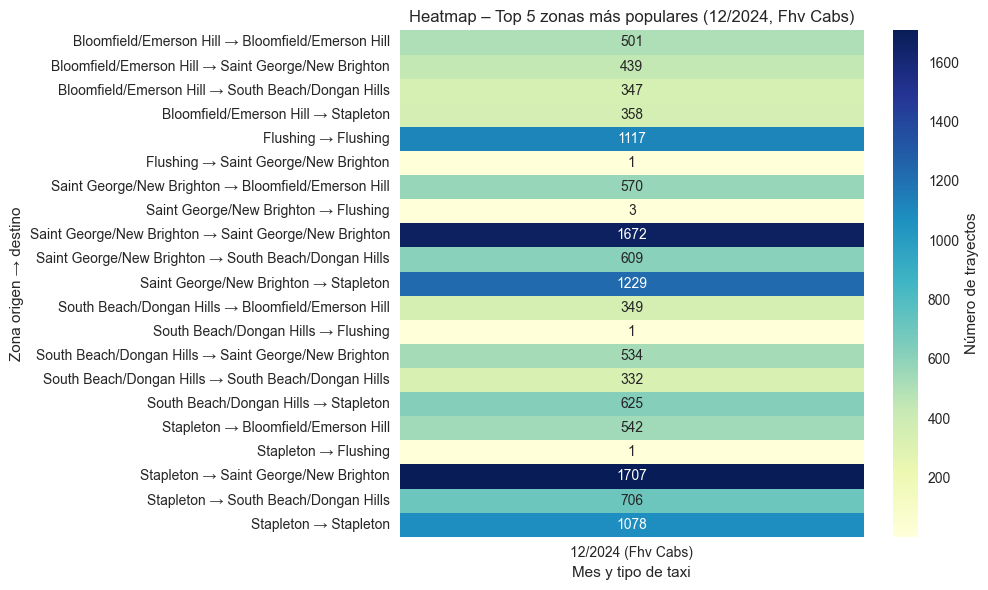

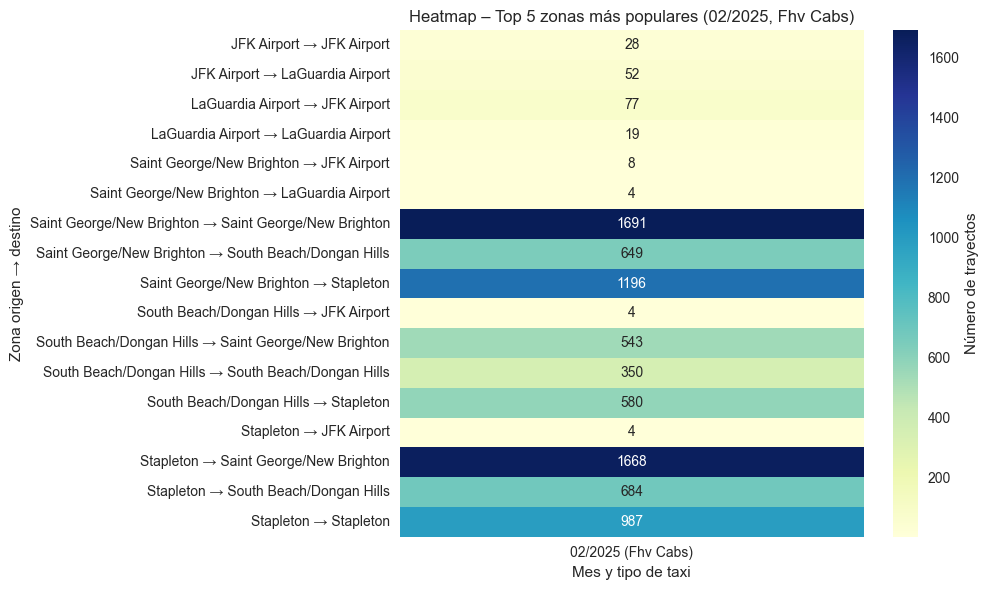

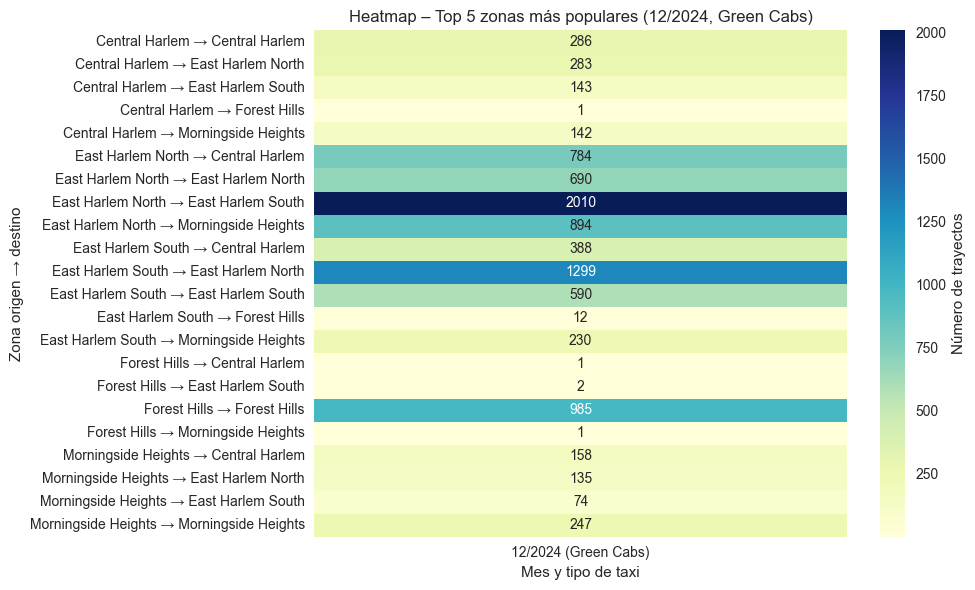

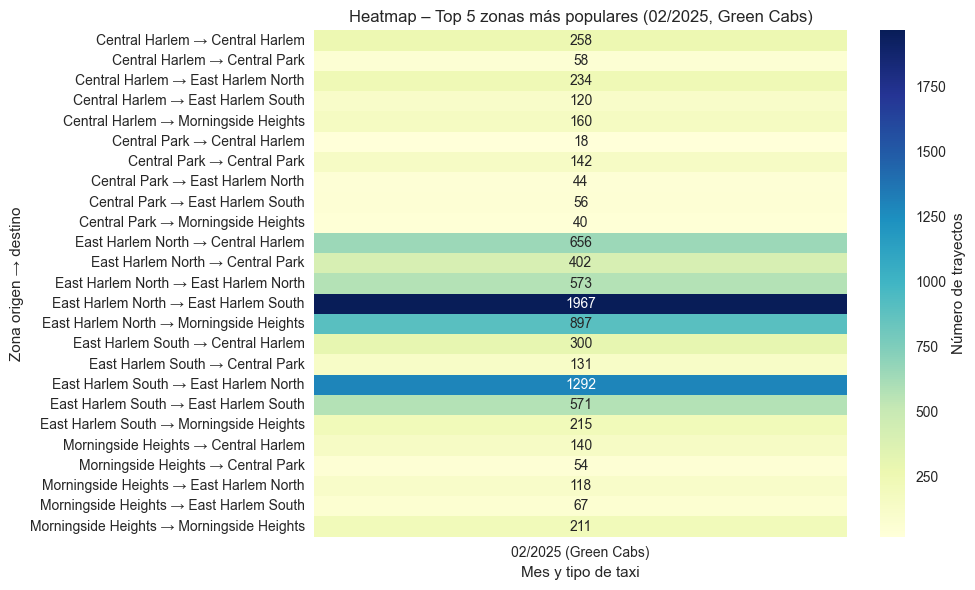

⚠️ yellow_tripdata_2009-02: columnas de ubicación no encontradas. Se omite.


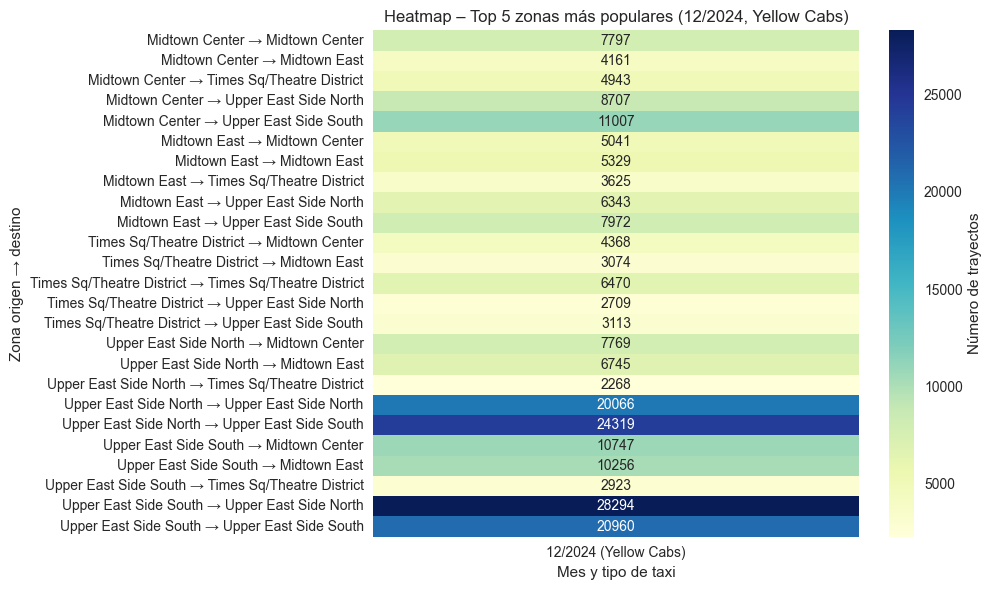

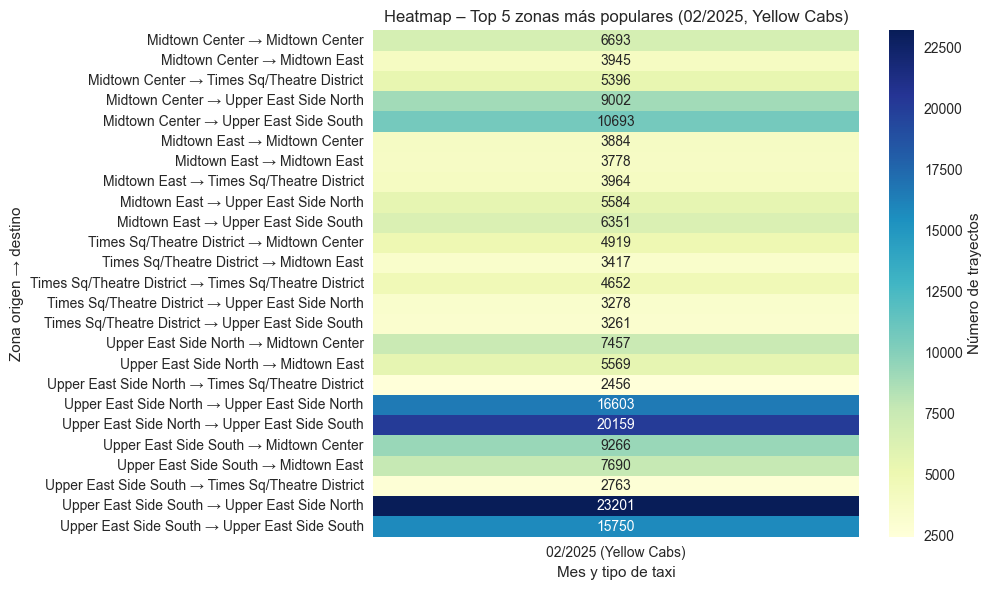

In [162]:
def plot_heatmap_top5_dict(datasets_dict):
    """
    Genera un heatmap con trayectos entre las 5 zonas más populares para cada dataset del diccionario.

    Se espera que las claves del diccionario sigan el formato: tipo_tripdata_aaaa-mm

    Parámetros:
    - datasets_dict: diccionario {nombre_dataset: DataFrame}
    """
    for key, df in datasets_dict.items():
        # Parsear tipo de taxi y fecha desde el nombre del archivo
        try:
            tipo, _, fecha = key.split("_")
            año, mes = fecha.split("-")
            mes_label = f"{mes}/{año}"
            nombre_dataset = tipo.capitalize() + " Cabs"
        except Exception as e:
            print(f"❌ No se pudo interpretar '{key}': {e}")
            continue

        # Verificar columnas necesarias
        if not all(col in df.columns for col in ["PULocationID", "DOLocationID"]):
            print(f"⚠️ {key}: columnas de ubicación no encontradas. Se omite.")
            continue

        # Agrupar trayectos
        zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

        # Zonas más activas (top 5 combinando origen y destino)
        zonas_frecuentes = pd.concat([
            zonas.groupby('PULocationID')['count'].sum(),
            zonas.groupby('DOLocationID')['count'].sum()
        ]).groupby(level=0).sum().nlargest(5).index.tolist()

        # Filtrar trayectos entre esas zonas
        zonas_top5 = zonas[
            zonas['PULocationID'].isin(zonas_frecuentes) &
            zonas['DOLocationID'].isin(zonas_frecuentes)
        ].copy()

        # Mapeo a nombres de zonas
        zonas_top5["Zona origen"] = zonas_top5["PULocationID"].map(zona_nombres)
        zonas_top5["Zona destino"] = zonas_top5["DOLocationID"].map(zona_nombres)

        # Crear clave de combinación
        zonas_top5["Zona"] = zonas_top5["Zona origen"] + " → " + zonas_top5["Zona destino"]
        zonas_top5["Mes-Tipo"] = f"{mes_label} ({nombre_dataset})"

        # Pivot para heatmap
        pivot_df = zonas_top5.pivot(index="Zona", columns="Mes-Tipo", values="count").fillna(0)

        # Dibujar heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Número de trayectos'})
        plt.title(f"Heatmap – Top 5 zonas más populares ({mes_label}, {nombre_dataset})")
        plt.ylabel("Zona origen → destino")
        plt.xlabel("Mes y tipo de taxi")
        plt.tight_layout()
        plt.show()

# Generamos heatmaps para los datasets Limpios
plot_heatmap_top5_dict(normalized_datasets)

# Segunda Parte: Análisis Cualitativo

## 2.1	¿Cuál es el trayecto en el que la relación precio/km es más alta? ¿Cuál es el trayecto en el que la relación tiempo/km es más alta? ¿Cuál es el trayecto en el que la relación precio/tiempo es más alta?

(Opcional) si hace falta se puede cargar el normalized_dataset original

In [163]:
# normalized_datasets
normalized_datasets = cargar_datasets_parquet("datasets_limpios")
# Verificar la carga
for name, df in normalized_datasets.items():
    print(f"{name}: {df.shape[0]:,} filas, {df.shape[1]} columnas")

📥 Cargando: fhvhv_tripdata_2024-12
📥 Cargando: fhvhv_tripdata_2025-02
📥 Cargando: fhv_tripdata_2024-12
📥 Cargando: fhv_tripdata_2025-02
📥 Cargando: green_tripdata_2024-12
📥 Cargando: green_tripdata_2025-02
📥 Cargando: yellow_tripdata_2009-02
📥 Cargando: yellow_tripdata_2024-12
📥 Cargando: yellow_tripdata_2025-02
fhvhv_tripdata_2024-12: 21,068,851 filas, 24 columnas
fhvhv_tripdata_2025-02: 19,339,461 filas, 25 columnas
fhv_tripdata_2024-12: 1,913,200 filas, 10 columnas
fhv_tripdata_2025-02: 1,578,722 filas, 10 columnas
green_tripdata_2024-12: 53,994 filas, 24 columnas
green_tripdata_2025-02: 46,621 filas, 25 columnas
yellow_tripdata_2009-02: 13,380,122 filas, 20 columnas
yellow_tripdata_2024-12: 3,668,371 filas, 23 columnas
yellow_tripdata_2025-02: 3,577,543 filas, 24 columnas


## Identificador de Outliers

In [164]:
def identificar_outliers_dict(datasets_dict):
    """
    Detecta outliers multivariables por IQR en cada dataset de un diccionario.
    Evalúa columnas como distancia, importe, duración y precio/km.

    Devuelve:
        dict con {nombre_dataset: DataFrame de outliers}
    """
    outliers_dict = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()
        print(f"\n📊 Procesando outliers en: {nombre}")

        # Calcular duración si no existe
        if "trip_duration_min" not in df.columns:
            pickup_cols = [c for c in ['tpep_pickup_datetime', 'lpep_pickup_datetime', 'pickup_datetime'] if c in df.columns]
            dropoff_cols = [c for c in ['tpep_dropoff_datetime', 'lpep_dropoff_datetime', 'dropoff_datetime', 'dropOff_datetime'] if c in df.columns]
            if pickup_cols and dropoff_cols:
                df["trip_duration_min"] = (
                    pd.to_datetime(df[dropoff_cols[0]], errors="coerce") -
                    pd.to_datetime(df[pickup_cols[0]], errors="coerce")
                ).dt.total_seconds() / 60

        # Calcular fare_per_km si procede
        if 'fare_amount' in df.columns and 'trip_distance' in df.columns:
            df = df[df['trip_distance'] > 0].copy()
            df['fare_per_km'] = df['fare_amount'] / df['trip_distance']

        # Columnas a evaluar
        columnas = ['trip_distance', 'fare_amount', 'trip_duration_min', 'fare_per_km']
        columnas = [col for col in columnas if col in df.columns]

        outlier_flags = pd.DataFrame(index=df.index)
        resumen = []

        for col in columnas:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lim_inf = Q1 - 1.5 * IQR
            lim_sup = Q3 + 1.5 * IQR

            flag = (df[col] < lim_inf) | (df[col] > lim_sup)
            outlier_flags[col + '_outlier'] = flag
            resumen.append((col, flag.sum(), lim_inf, lim_sup))

        outlier_rows = df[outlier_flags.any(axis=1)].copy()
        if not outlier_rows.empty:
            outlier_rows['Outlier en'] = outlier_flags[outlier_flags.any(axis=1)].apply(
                lambda x: ', '.join(x.index[x]), axis=1
            )
            outliers_dict[nombre] = outlier_rows

        # Mostrar resumen
        for col, count, low, high in resumen:
            print(f"  ▪ {col}: {count} outliers (fuera de [{low:.2f}, {high:.2f}])")

    return outliers_dict
# Identificar outliers en los datasets limpios
outliers_detectados = identificar_outliers_dict(normalized_datasets)


📊 Procesando outliers en: fhvhv_tripdata_2024-12
  ▪ trip_distance: 1628477 outliers (fuera de [-5.81, 13.73])
  ▪ trip_duration_min: 995187 outliers (fuera de [-15.05, 51.48])

📊 Procesando outliers en: fhvhv_tripdata_2025-02
  ▪ trip_distance: 1474251 outliers (fuera de [-5.47, 13.09])
  ▪ trip_duration_min: 778237 outliers (fuera de [-12.63, 46.64])

📊 Procesando outliers en: fhv_tripdata_2024-12
  ▪ trip_duration_min: 124785 outliers (fuera de [-19.82, 59.92])

📊 Procesando outliers en: fhv_tripdata_2025-02
  ▪ trip_duration_min: 85626 outliers (fuera de [-17.90, 57.83])

📊 Procesando outliers en: green_tripdata_2024-12
  ▪ trip_distance: 5144 outliers (fuera de [-1.62, 5.94])
  ▪ fare_amount: 4060 outliers (fuera de [-7.50, 37.30])
  ▪ trip_duration_min: 3601 outliers (fuera de [-8.52, 34.02])
  ▪ fare_per_km: 4270 outliers (fuera de [1.76, 12.65])

📊 Procesando outliers en: green_tripdata_2025-02
  ▪ trip_distance: 4583 outliers (fuera de [-1.57, 5.84])
  ▪ fare_amount: 3567 out

In [165]:
normalized_datasets['yellow_tripdata_2009-02'].columns


Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'Trip_Distance', 'Start_Lon', 'Start_Lat', 'RatecodeID',
       'store_and_fwd_flag', 'End_Lon', 'End_Lat', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tips', 'tolls', 'total_amount',
       'same_location_flag', 'suspicious_location_flag'],
      dtype='object')

###  Muestra un resumen por DataSet de registros con incoherencias entre distancia y precio. 

In [166]:
def analizar_incoherencias_distancia_precio(datasets_dict, z_thresh=3.0, min_registros=100):
    """
    Analiza incoherencias entre trip_distance y fare_amount usando regresión lineal.
    No modifica los datasets. Solo informa.

    Parámetros:
    - datasets_dict: diccionario {nombre: DataFrame}
    - z_thresh: umbral de Z-score para considerar un registro incoherente
    - min_registros: mínimo de registros para aplicar regresión

    Muestra un resumen con el número de incoherencias detectadas por dataset.
    """
    resumen = []

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Validar columnas necesarias
        if "trip_distance" not in df.columns or "fare_amount" not in df.columns:
            print(f"❌ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        # Filtrar registros válidos
        df_validos = df[
            df["trip_distance"].notnull() &
            df["fare_amount"].notnull() &
            (df["trip_distance"] > 0) &
            (df["fare_amount"] > 0)
        ]

        if len(df_validos) < min_registros:
            print(f"⚠️ {nombre}: solo {len(df_validos)} registros válidos. Se omite.")
            continue

        # Regresión lineal
        X = df_validos[["trip_distance"]].values
        y = df_validos["fare_amount"].values
        modelo = LinearRegression()
        modelo.fit(X, y)

        # Calcular residuos y z-score
        y_pred = modelo.predict(X)
        residuos = y - y_pred
        z_residuos = zscore(residuos)

        # Identificar incoherencias
        incoherentes = (abs(z_residuos) > z_thresh).sum()
        total = len(df_validos)
        porcentaje = 100 * incoherentes / total

        resumen.append({
            "Dataset": nombre,
            "Registros válidos": total,
            "Incoherencias (> z_thresh)": incoherentes,
            "% Incoherente": f"{porcentaje:.2f}%"
        })

    # Mostrar resumen
    print("\n📊 Resumen de incoherencias entre distancia y precio (regresión):")
    display(pd.DataFrame(resumen))

# Ejemplo de uso
analizar_incoherencias_distancia_precio(normalized_datasets, 3)


❌ fhvhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite.
❌ fhvhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite.
❌ fhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite.
❌ fhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite.
❌ yellow_tripdata_2009-02: columnas necesarias no encontradas. Se omite.

📊 Resumen de incoherencias entre distancia y precio (regresión):


,Dataset,Registros válidos,Incoherencias (> z_thresh),% Incoherente
0,green_tripdata_2024-12,53785,747,1.39%
1,green_tripdata_2025-02,46407,846,1.82%
2,yellow_tripdata_2024-12,3587874,47523,1.32%
3,yellow_tripdata_2025-02,3393447,530,0.02%


### Imputar la media local/global en las incoherencias entre distancia y precio detectadas por regresión.

In [167]:
# Imputación de valores anómalos de fare_amount por regresión lineal
def imputar_fare_anomalo_por_regresion(datasets_dict, z_thresh=3.0, min_similares=5):
    """
    Imputa valores incoherentes en 'fare_amount' usando regresión lineal contra 'trip_distance'.
    La imputación se realiza sólo para registros válidos que sean outliers:
    - Primero intenta usar la media local por trayecto (PU-DO).
    - Si no hay suficientes trayectos, usa la media global.
    """

    corregidos = {}
    resumen = []

    for nombre, df_original in datasets_dict.items():
        if not all(col in df_original.columns for col in ["trip_distance", "fare_amount", "PULocationID", "DOLocationID"]):
            print(f"❌ {nombre}: columnas necesarias no encontradas. Se omite imputación.")
            corregidos[nombre] = df_original.copy()
            continue


        print(f"🔍 Procesando: {nombre}")
        df = df_original.copy()
        df["fare_imputed_by_regression"] = False

        # Filtrar registros válidos
        valid_mask = (df["trip_distance"] > 0) & (df["fare_amount"] > 0)
        df_valid = df[valid_mask].copy()

        if len(df_valid) < 1000:
            print(f"⚠️ {nombre}: muy pocos registros válidos. Se mantiene sin imputación.")
            corregidos[nombre] = df
            continue

        # Entrenar regresión
        X = df_valid[["trip_distance"]].values
        y = df_valid["fare_amount"].values
        modelo = LinearRegression()
        modelo.fit(X, y)
        y_pred = modelo.predict(X)

        # Detectar outliers por residuos
        residuos = y - y_pred
        z_residuos = zscore(residuos)
        df_valid["fare_residuo_z"] = z_residuos
        outliers = df_valid[abs(z_residuos) > z_thresh]

        if outliers.empty:
            print(f"ℹ️ {nombre}: sin outliers detectados. No se requiere imputación.")
            corregidos[nombre] = df
            continue

        # Calcular medias locales
        normales = df_valid[abs(z_residuos) <= z_thresh]
        conteo = normales.groupby(["PULocationID", "DOLocationID"]).size().reset_index(name="count")
        frecuentes = conteo[conteo["count"] >= min_similares][["PULocationID", "DOLocationID"]]
        medias_locales = (
            normales.groupby(["PULocationID", "DOLocationID"])["fare_amount"]
            .mean()
            .reset_index()
            .rename(columns={"fare_amount": "fare_local"})
            .merge(frecuentes, on=["PULocationID", "DOLocationID"])
        )

        media_global = normales["fare_amount"].mean()

        # Reemplazo de valores
        imputados = outliers.merge(medias_locales, on=["PULocationID", "DOLocationID"], how="left")
        imputados["fare_amount"] = imputados["fare_local"].fillna(media_global)
        imputados["fare_imputed_by_regression"] = True

        # Aplicar imputaciones al dataframe original
        df.update(imputados[["fare_amount", "fare_imputed_by_regression"]])

        # Guardar resultados
        corregidos[nombre] = df
        resumen.append({
            "Dataset": nombre,
            "Registros válidos": len(df_valid),
            "Outliers": len(imputados),
            "Imputados local": imputados["fare_local"].notna().sum(),
            "Imputados global": imputados["fare_local"].isna().sum()
        })

    if resumen:
        resumen_df = pd.DataFrame(resumen)
        resumen_df["% Imputados"] = ((resumen_df["Outliers"]) / resumen_df["Registros válidos"] * 100).round(2)
        print("\n📊 Resumen de imputaciones (fare vs distance):")
        display(resumen_df)

    return corregidos

# Ejecutar función sobre normalized_datasets
normalized_datasets = imputar_fare_anomalo_por_regresion(normalized_datasets,3)

❌ fhvhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite imputación.
❌ fhvhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite imputación.
❌ fhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite imputación.
❌ fhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite imputación.
🔍 Procesando: green_tripdata_2024-12
🔍 Procesando: green_tripdata_2025-02
❌ yellow_tripdata_2009-02: columnas necesarias no encontradas. Se omite imputación.
🔍 Procesando: yellow_tripdata_2024-12
🔍 Procesando: yellow_tripdata_2025-02

📊 Resumen de imputaciones (fare vs distance):


,Dataset,Registros válidos,Outliers,Imputados local,Imputados global,% Imputados
0,green_tripdata_2024-12,53785,747,264,483,1.39
1,green_tripdata_2025-02,46407,846,221,625,1.82
2,yellow_tripdata_2024-12,3587874,47523,41127,6396,1.32
3,yellow_tripdata_2025-02,3393447,530,521,9,0.02


### Comprobación tras Imputación

In [168]:
analizar_incoherencias_distancia_precio(normalized_datasets,3)

❌ fhvhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite.
❌ fhvhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite.
❌ fhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite.
❌ fhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite.
❌ yellow_tripdata_2009-02: columnas necesarias no encontradas. Se omite.

📊 Resumen de incoherencias entre distancia y precio (regresión):


,Dataset,Registros válidos,Incoherencias (> z_thresh),% Incoherente
0,green_tripdata_2024-12,53788,730,1.36%
1,green_tripdata_2025-02,46407,854,1.84%
2,yellow_tripdata_2024-12,3588987,45660,1.27%
3,yellow_tripdata_2025-02,3393449,530,0.02%


### Trayecto con mayor precio por km

In [169]:
def trayecto_mayor_precio_por_km(datasets_dict):
    """
    Encuentra el trayecto con la mayor relación precio/km para cada dataset
    y también a nivel global, usando nombres reales de zona.

    Parámetros:
        datasets_dict (dict): {nombre_dataset: DataFrame}

    Retorna:
        DataFrame con los trayectos con mayor precio/km por dataset y global.
    """
    resumen = []
    global_max = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        if not all(col in df.columns for col in ["trip_distance", "fare_amount", "PULocationID", "DOLocationID"]):
            print(f"⚠️ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        df = df[(df["trip_distance"] > 0) & (df["fare_amount"] > 0)].copy()
        if df.empty:
            print(f"⚠️ {nombre}: sin registros válidos para calcular precio/km.")
            continue

        df["fare_per_km"] = df["fare_amount"] / df["trip_distance"]
        top = df.loc[df["fare_per_km"].idxmax()]

        resumen.append({
            "Dataset": nombre,
            "Origen": f"{int(top['PULocationID'])} - {zona_nombres.get(top['PULocationID'], 'Desconocido')}",
            "Destino": f"{int(top['DOLocationID'])} - {zona_nombres.get(top['DOLocationID'], 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Precio ($)": top["fare_amount"],
            "Precio/km ($)": top["fare_per_km"]
        })

        if global_max is None or top["fare_per_km"] > global_max["fare_per_km"]:
            global_max = top
            global_name = nombre

    if global_max is not None:
        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{int(global_max['PULocationID'])} - {zona_nombres.get(global_max['PULocationID'], 'Desconocido')}",
            "Destino": f"{int(global_max['DOLocationID'])} - {zona_nombres.get(global_max['DOLocationID'], 'Desconocido')}",
            "Distancia (mi)": global_max["trip_distance"],
            "Precio ($)": global_max["fare_amount"],
            "Precio/km ($)": global_max["fare_per_km"]
        })

    return pd.DataFrame(resumen)

# Ejecutar la función para encontrar el trayecto con mayor precio/km
trayecto_mayor_precio_por_km(normalized_datasets)

⚠️ fhvhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite.
⚠️ fhvhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite.
⚠️ fhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite.
⚠️ fhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite.
⚠️ yellow_tripdata_2009-02: columnas necesarias no encontradas. Se omite.


,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($)
0,green_tripdata_2024-12,93 - Flushing Meadows-Corona Park,93 - Flushing Meadows-Corona Park,0.03,300.00,10000.000000
1,green_tripdata_2025-02,43 - Central Park,43 - Central Park,0.01,70.00,7000.000000
2,yellow_tripdata_2024-12,133 - Kensington,257 - Windsor Terrace,0.01,550.00,55000.000000
3,yellow_tripdata_2025-02,161 - Midtown Center,246 - West Chelsea/Hudson Yards,2.20,132531.36,60241.527273
4,GLOBAL (yellow_tripdata_2025-02),161 - Midtown Center,246 - West Chelsea/Hudson Yards,2.20,132531.36,60241.527273


### Trayecto con la relación tiempo/km más alta

In [170]:
def trayecto_mayor_duracion_por_km(datasets_dict):
    """
    Encuentra el trayecto con mayor duración por kilómetro para cada dataset
    y también a nivel global, incluyendo nombres de zona.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}

    Retorna:
        DataFrame resumen con los trayectos más lentos (min/km)
    """
    resumen = []
    global_max = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Detectar columnas de datetime
        pickup_cols = [col for col in df.columns if 'pickup' in col and 'datetime' in col]
        dropoff_cols = [col for col in df.columns if 'drop' in col and 'datetime' in col]

        if not pickup_cols or not dropoff_cols:
            print(f"⚠️ {nombre}: columnas de datetime no encontradas. Se omite.")
            continue

        pickup = pd.to_datetime(df[pickup_cols[0]], errors='coerce')
        dropoff = pd.to_datetime(df[dropoff_cols[0]], errors='coerce')
        df["duration_min"] = (dropoff - pickup).dt.total_seconds() / 60

        if "trip_distance" not in df.columns:
            print(f"⚠️ {nombre}: columna 'trip_distance' no encontrada. Se omite.")
            continue

        df = df[(df["trip_distance"] > 0) & (df["duration_min"] > 0)].copy()

        if df.empty:
            print(f"⚠️ {nombre}: sin registros válidos tras filtrado. Se omite.")
            continue

        df["min_per_km"] = df["duration_min"] / df["trip_distance"]

        top = df.loc[df["min_per_km"].idxmax()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resumen.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Duración (min)": top["duration_min"],
            "Min/km": top["min_per_km"]
        })

        if global_max is None or top["min_per_km"] > global_max["min_per_km"]:
            global_max = top
            global_name = nombre

    if global_max is not None:
        origen_id = int(global_max["PULocationID"])
        destino_id = int(global_max["DOLocationID"])
        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": global_max["trip_distance"],
            "Duración (min)": global_max["duration_min"],
            "Min/km": global_max["min_per_km"]
        })

    return pd.DataFrame(resumen)

# Ejecutar la función para encontrar el trayecto con mayor duración por kilómetro
trayecto_mayor_duracion_por_km(normalized_datasets)

⚠️ fhv_tripdata_2024-12: columna 'trip_distance' no encontrada. Se omite.
⚠️ fhv_tripdata_2025-02: columna 'trip_distance' no encontrada. Se omite.
⚠️ yellow_tripdata_2009-02: columna 'trip_distance' no encontrada. Se omite.


,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km
0,fhvhv_tripdata_2024-12,181 - Park Slope,181 - Park Slope,0.01,122.933333,12293.333333
1,fhvhv_tripdata_2025-02,216 - South Ozone Park,216 - South Ozone Park,0.01,190.900000,19090.000000
2,green_tripdata_2024-12,149 - Madison,149 - Madison,0.26,1256.716667,4833.525641
3,green_tripdata_2025-02,83 - Elmhurst/Maspeth,83 - Elmhurst/Maspeth,0.01,1395.200000,139520.000000
4,yellow_tripdata_2024-12,14 - Bay Ridge,172 - New Dorp/Midland Beach,0.01,860.133333,86013.333333
5,yellow_tripdata_2025-02,34 - Brooklyn Navy Yard,256 - Williamsburg (South Side),0.02,1439.000000,71950.000000
6,GLOBAL (green_tripdata_2025-02),83 - Elmhurst/Maspeth,83 - Elmhurst/Maspeth,0.01,1395.200000,139520.000000


### Trayecto con relación precio/tiempo más alta

In [172]:
def trayecto_mayor_precio_por_minuto(datasets_dict):
    """
    Encuentra el trayecto con mayor relación precio/tiempo para cada dataset
    (es decir, el mayor coste por minuto), e identifica también el global.
    """
    resumen = []
    global_max = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Detectar columnas de tiempo
        pickup_cols = [col for col in df.columns if 'pickup' in col and 'datetime' in col]
        dropoff_cols = [col for col in df.columns if 'drop' in col and 'datetime' in col]
        if not pickup_cols or not dropoff_cols:
            print(f"⚠️ {nombre}: columnas de tiempo no encontradas. Se omite.")
            continue

        # Calcular duración en minutos
        pickup = pd.to_datetime(df[pickup_cols[0]], errors='coerce')
        dropoff = pd.to_datetime(df[dropoff_cols[0]], errors='coerce')
        df["duration_min"] = (dropoff - pickup).dt.total_seconds() / 60

        if "fare_amount" not in df.columns:
            print(f"⚠️ {nombre}: columna 'fare_amount' no encontrada. Se omite.")
            continue

        # Filtrar registros válidos
        df = df[(df["duration_min"] > 0) & (df["fare_amount"] > 0)].copy()

        # Calcular $ por minuto
        df["usd_per_min"] = df["fare_amount"] / df["duration_min"]

        if df.empty:
            continue

        top = df.loc[df["usd_per_min"].idxmax()]

        # Manejo seguro de columnas de localización
        origen_id = int(top["PULocationID"]) if "PULocationID" in top else None
        destino_id = int(top["DOLocationID"]) if "DOLocationID" in top else None

        resumen.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}" if origen_id else "N/A",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}" if destino_id else "N/A",
            "Duración (min)": top["duration_min"],
            "Precio ($)": top["fare_amount"],
            "$/min": top["usd_per_min"]
        })

        if global_max is None or top["usd_per_min"] > global_max["usd_per_min"]:
            global_max = top
            global_name = nombre

    # Agregar global
    if global_max is not None:
        origen_id = int(global_max["PULocationID"]) if "PULocationID" in global_max else None
        destino_id = int(global_max["DOLocationID"]) if "DOLocationID" in global_max else None

        resumen.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}" if origen_id else "N/A",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}" if destino_id else "N/A",
            "Duración (min)": global_max["duration_min"],
            "Precio ($)": global_max["fare_amount"],
            "$/min": global_max["usd_per_min"]
        })

    return pd.DataFrame(resumen)



# Ejecutar la función para encontrar el trayecto con mayor precio por minuto
trayecto_mayor_precio_por_minuto(normalized_datasets)


⚠️ fhvhv_tripdata_2024-12: columna 'fare_amount' no encontrada. Se omite.
⚠️ fhvhv_tripdata_2025-02: columna 'fare_amount' no encontrada. Se omite.
⚠️ fhv_tripdata_2024-12: columna 'fare_amount' no encontrada. Se omite.
⚠️ fhv_tripdata_2025-02: columna 'fare_amount' no encontrada. Se omite.


,Dataset,Origen,Destino,Duración (min),Precio ($),$/min
0,green_tripdata_2024-12,92 - Flushing,264 - nan,0.050000,300.00,6000.00
1,green_tripdata_2025-02,265 - Outside of NYC,265 - Outside of NYC,0.033333,155.00,4650.00
2,yellow_tripdata_2009-02,N/A,N/A,0.016667,120.00,7200.00
3,yellow_tripdata_2024-12,3 - Allerton/Pelham Gardens,3 - Allerton/Pelham Gardens,0.033333,655.35,19660.50
4,yellow_tripdata_2025-02,169 - Mount Hope,169 - Mount Hope,0.066667,833.55,12503.25
5,GLOBAL (yellow_tripdata_2024-12),3 - Allerton/Pelham Gardens,3 - Allerton/Pelham Gardens,0.033333,655.35,19660.50


## 2.2	¿Cuál es el trayecto en el que la relación precio/km es más baja? 

In [176]:
def trayecto_menor_precio_por_km(datasets_dict, min_distance=0.1):
    """
    Encuentra el trayecto con menor relación precio/km para cada dataset,
    ignorando trayectos con distancia menor al umbral especificado.
    También encuentra el trayecto global con la relación más baja.

    Parámetros:
        datasets_dict: diccionario {nombre: DataFrame}
        min_distance: distancia mínima (en millas) para considerar un trayecto

    Retorna:
        DataFrame con los trayectos más baratos por km
    """
    resultados = []
    global_min = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()
        if not all(col in df.columns for col in ["trip_distance", "fare_amount", "PULocationID", "DOLocationID"]):
            print(f"⚠️ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        df = df[
            (df["trip_distance"] >= min_distance) &
            (df["fare_amount"] > 0)
        ].copy()

        if df.empty:
            continue

        df["fare_per_km"] = df["fare_amount"] / df["trip_distance"]

        top = df.loc[df["fare_per_km"].idxmin()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resultados.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Precio ($)": top["fare_amount"],
            "Precio/km ($)": top["fare_per_km"]
        })

        if global_min is None or top["fare_per_km"] < global_min["fare_per_km"]:
            global_min = top
            global_name = nombre

    if global_min is not None:
        origen_id = int(global_min["PULocationID"])
        destino_id = int(global_min["DOLocationID"])
        resultados.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": global_min["trip_distance"],
            "Precio ($)": global_min["fare_amount"],
            "Precio/km ($)": global_min["fare_per_km"]
        })

    return pd.DataFrame(resultados)


# Ejecutar la función para encontrar el trayecto con menor precio/km
trayecto_menor_precio_por_km(normalized_datasets, min_distance=0.1)


⚠️ fhvhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite.
⚠️ fhvhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite.
⚠️ fhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite.
⚠️ fhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite.
⚠️ yellow_tripdata_2009-02: columnas necesarias no encontradas. Se omite.


,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($)
0,green_tripdata_2024-12,61 - Crown Heights North,61 - Crown Heights North,64935.37,12.62,0.000194
1,green_tripdata_2025-02,41 - Central Harlem,229 - Sutton Place/Turtle Bay North,111597.19,24.37,0.000218
2,yellow_tripdata_2024-12,116 - Hamilton Heights,238 - Upper West Side North,64075.70,0.16,0.000002
3,yellow_tripdata_2025-02,178 - Ocean Parkway South,165 - Midwood,117163.99,5.73,0.000049
4,GLOBAL (yellow_tripdata_2024-12),116 - Hamilton Heights,238 - Upper West Side North,64075.70,0.16,0.000002


### ¿Cuál es el trayecto en el que la relación tiempo/km es más baja? 

In [174]:
def trayecto_menor_tiempo_por_km(datasets_dict):
    """
    Encuentra el trayecto con menor relación tiempo/km (minutos por milla) para cada dataset,
    así como el trayecto global con la menor relación.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}

    Retorna:
        DataFrame con los trayectos más rápidos por km
    """
    resultados = []
    global_min = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        if "trip_distance" not in df.columns:
            print(f"⚠️ {nombre}: sin columna 'trip_distance'. Se omite.")
            continue

        df = df[df["trip_distance"] > 0]

        if "trip_duration_min" not in df.columns:
            pickup_cols = [c for c in df.columns if "pickup" in c and "datetime" in c]
            dropoff_cols = [c for c in df.columns if "drop" in c and "datetime" in c]
            if pickup_cols and dropoff_cols:
                df["trip_duration_min"] = (
                    pd.to_datetime(df[dropoff_cols[0]], errors='coerce') -
                    pd.to_datetime(df[pickup_cols[0]], errors='coerce')
                ).dt.total_seconds() / 60
            else:
                print(f"⚠️ {nombre}: sin columnas de fecha válidas. Se omite.")
                continue

        df = df[df["trip_duration_min"] > 0]
        df["min_per_km"] = df["trip_duration_min"] / df["trip_distance"]

        if df.empty:
            continue

        top = df.loc[df["min_per_km"].idxmin()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resultados.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Duración (min)": top["trip_duration_min"],
            "Min/km": top["min_per_km"]
        })

        if global_min is None or top["min_per_km"] < global_min["min_per_km"]:
            global_min = top
            global_name = nombre

    if global_min is not None:
        origen_id = int(global_min["PULocationID"])
        destino_id = int(global_min["DOLocationID"])
        resultados.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": global_min["trip_distance"],
            "Duración (min)": global_min["trip_duration_min"],
            "Min/km": global_min["min_per_km"]
        })

    return pd.DataFrame(resultados)

# Ejecutar la función para encontrar el trayecto con menor tiempo/km
trayecto_menor_tiempo_por_km(normalized_datasets)

⚠️ fhv_tripdata_2024-12: sin columna 'trip_distance'. Se omite.
⚠️ fhv_tripdata_2025-02: sin columna 'trip_distance'. Se omite.
⚠️ yellow_tripdata_2009-02: sin columna 'trip_distance'. Se omite.


,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km
0,fhvhv_tripdata_2024-12,138 - LaGuardia Airport,265 - Outside of NYC,23.55,0.016667,0.000708
1,fhvhv_tripdata_2025-02,132 - JFK Airport,181 - Park Slope,19.66,0.016667,0.000848
2,green_tripdata_2024-12,61 - Crown Heights North,61 - Crown Heights North,64935.37,9.000000,0.000139
3,green_tripdata_2025-02,7 - Astoria,193 - Queensbridge/Ravenswood,35783.89,3.000000,0.000084
4,yellow_tripdata_2024-12,137 - Kips Bay,186 - Penn Station/Madison Sq West,328827.63,5.000000,0.000015
5,yellow_tripdata_2025-02,87 - Financial District North,87 - Financial District North,88360.34,1.000000,0.000011
6,GLOBAL (yellow_tripdata_2025-02),87 - Financial District North,87 - Financial District North,88360.34,1.000000,0.000011


### ¿Cuál es el trayecto en el que la relación precio/tiempo es más baja?

In [178]:
def trayecto_menor_precio_por_minuto(datasets_dict):
    """
    Encuentra el trayecto con menor relación precio/tiempo (USD por minuto) para cada dataset
    y el trayecto global con la menor relación.
    """
    resultados = []
    global_min = None
    global_name = None

    for nombre, df in datasets_dict.items():
        df = df.copy()

        if "fare_amount" not in df.columns:
            print(f"⚠️ {nombre}: columna 'fare_amount' no encontrada. Se omite.")
            continue

        df = df[df["fare_amount"] > 0]

        # Calcular duración si no existe
        if "trip_duration_min" not in df.columns:
            pickup_cols = [col for col in df.columns if "pickup" in col and "datetime" in col]
            dropoff_cols = [col for col in df.columns if "drop" in col and "datetime" in col]
            if pickup_cols and dropoff_cols:
                df["trip_duration_min"] = (
                    pd.to_datetime(df[dropoff_cols[0]], errors="coerce") -
                    pd.to_datetime(df[pickup_cols[0]], errors="coerce")
                ).dt.total_seconds() / 60
            else:
                print(f"⚠️ {nombre}: sin columnas de fecha válidas. Se omite.")
                continue

        df = df[df["trip_duration_min"] > 0]
        df["usd_per_min"] = df["fare_amount"] / df["trip_duration_min"]

        if df.empty:
            continue

        top = df.loc[df["usd_per_min"].idxmin()]

        # Manejo seguro de IDs de localización
        origen_id = int(top["PULocationID"]) if "PULocationID" in top else None
        destino_id = int(top["DOLocationID"]) if "DOLocationID" in top else None

        resultados.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}" if origen_id else "N/A",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}" if destino_id else "N/A",
            "Duración (min)": top["trip_duration_min"],
            "Precio ($)": top["fare_amount"],
            "Precio/min ($)": top["usd_per_min"]
        })

        if global_min is None or top["usd_per_min"] < global_min["usd_per_min"]:
            global_min = top
            global_name = nombre

    # Trayecto global
    if global_min is not None:
        origen_id = int(global_min["PULocationID"]) if "PULocationID" in global_min else None
        destino_id = int(global_min["DOLocationID"]) if "DOLocationID" in global_min else None

        resultados.append({
            "Dataset": f"GLOBAL ({global_name})",
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}" if origen_id else "N/A",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}" if destino_id else "N/A",
            "Duración (min)": global_min["trip_duration_min"],
            "Precio ($)": global_min["fare_amount"],
            "Precio/min ($)": global_min["usd_per_min"]
        })

    return pd.DataFrame(resultados)


# Ejecutar la función para encontrar el trayecto con menor precio por minuto
trayecto_menor_precio_por_minuto(normalized_datasets)

⚠️ fhvhv_tripdata_2024-12: columna 'fare_amount' no encontrada. Se omite.
⚠️ fhvhv_tripdata_2025-02: columna 'fare_amount' no encontrada. Se omite.
⚠️ fhv_tripdata_2024-12: columna 'fare_amount' no encontrada. Se omite.
⚠️ fhv_tripdata_2025-02: columna 'fare_amount' no encontrada. Se omite.


,Dataset,Origen,Destino,Duración (min),Precio ($),Precio/min ($)
0,green_tripdata_2024-12,75 - East Harlem South,41 - Central Harlem,1427.266667,5.80,0.004064
1,green_tripdata_2025-02,41 - Central Harlem,41 - Central Harlem,1433.183333,5.10,0.003559
2,yellow_tripdata_2009-02,N/A,N/A,50492.016667,2.50,0.000050
3,yellow_tripdata_2024-12,195 - Red Hook,6 - Arrochar/Fort Wadsworth,1093.116667,0.01,0.000009
4,yellow_tripdata_2025-02,227 - Sunset Park East,6 - Arrochar/Fort Wadsworth,803.600000,0.01,0.000012
5,GLOBAL (yellow_tripdata_2024-12),195 - Red Hook,6 - Arrochar/Fort Wadsworth,1093.116667,0.01,0.000009


## 2.3	Muestra la evolución del tiempo medio de trayecto a lo largo del día. 

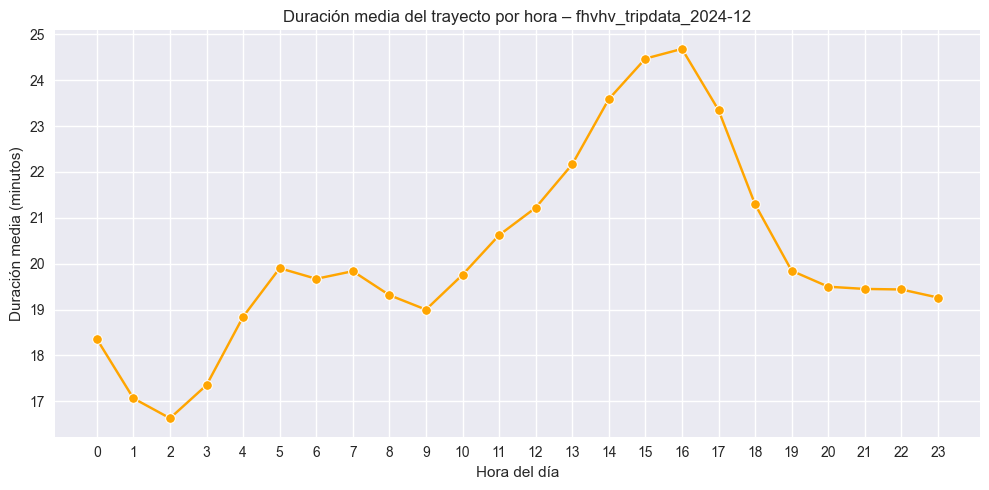

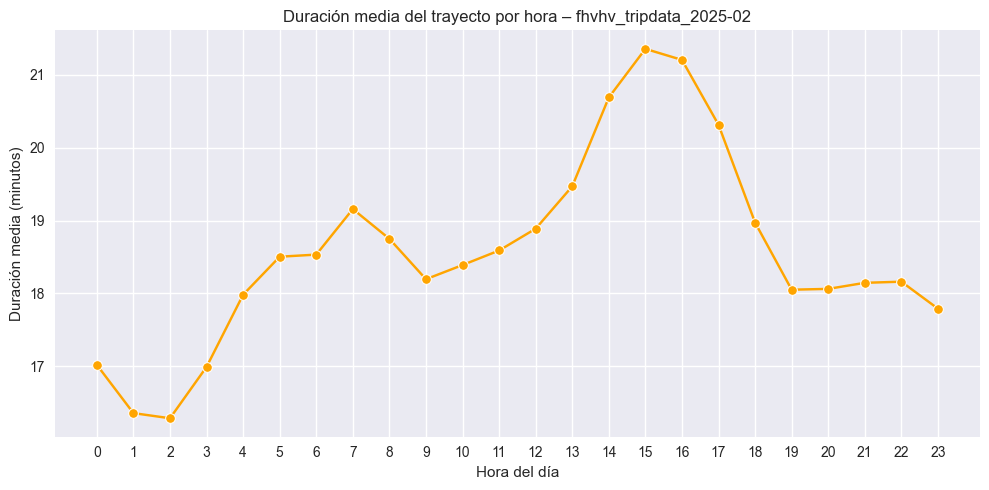

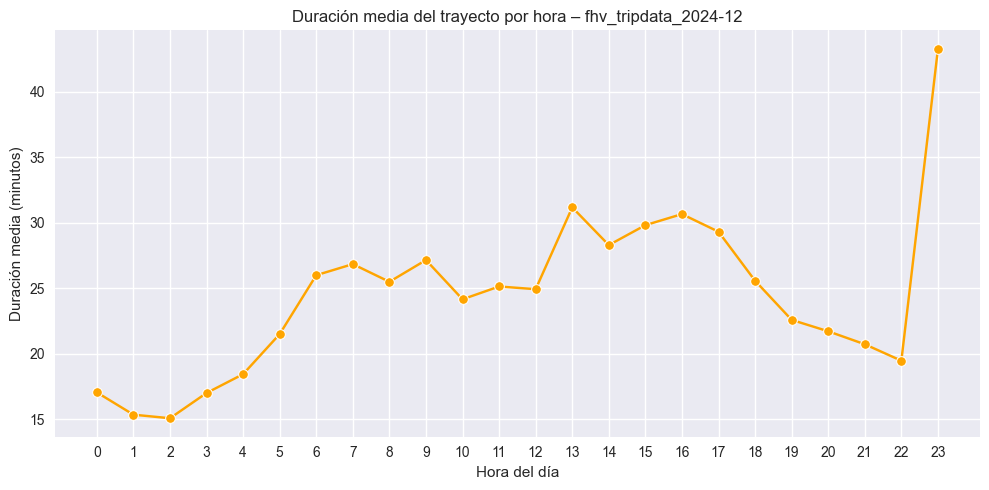

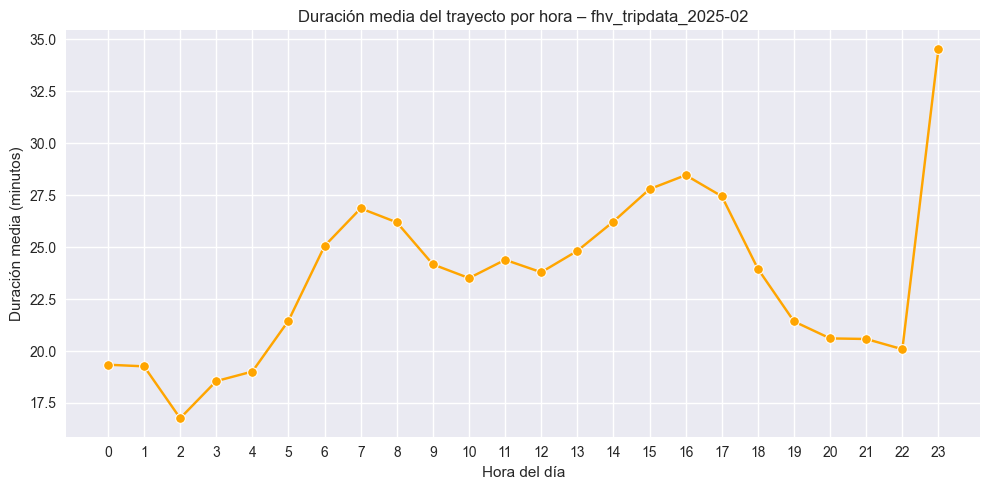

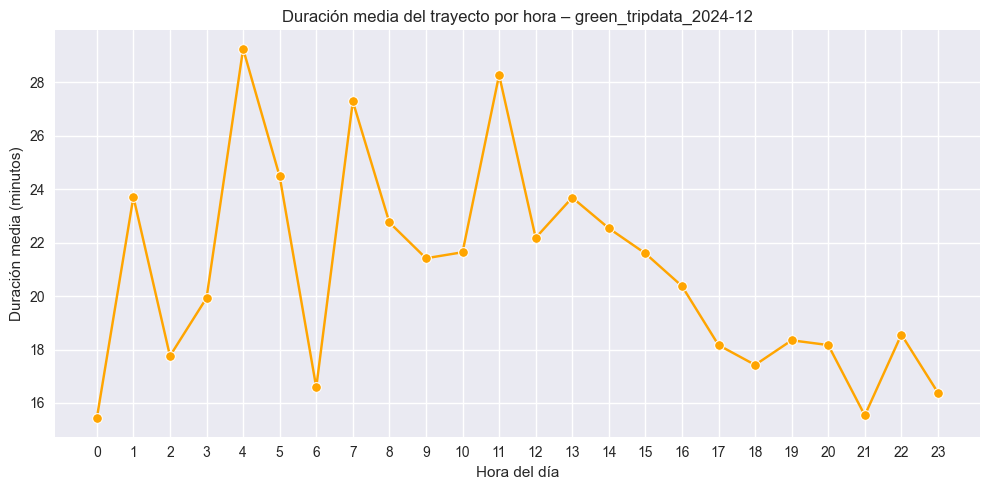

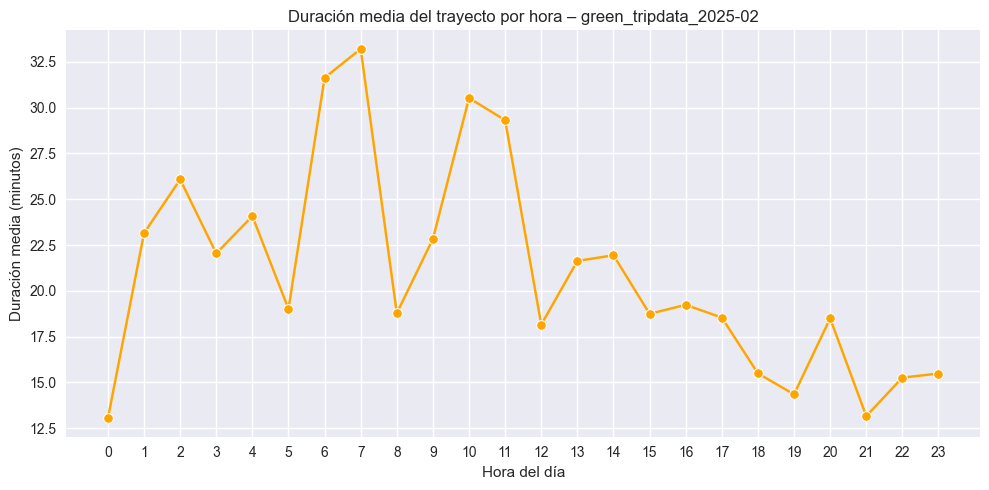

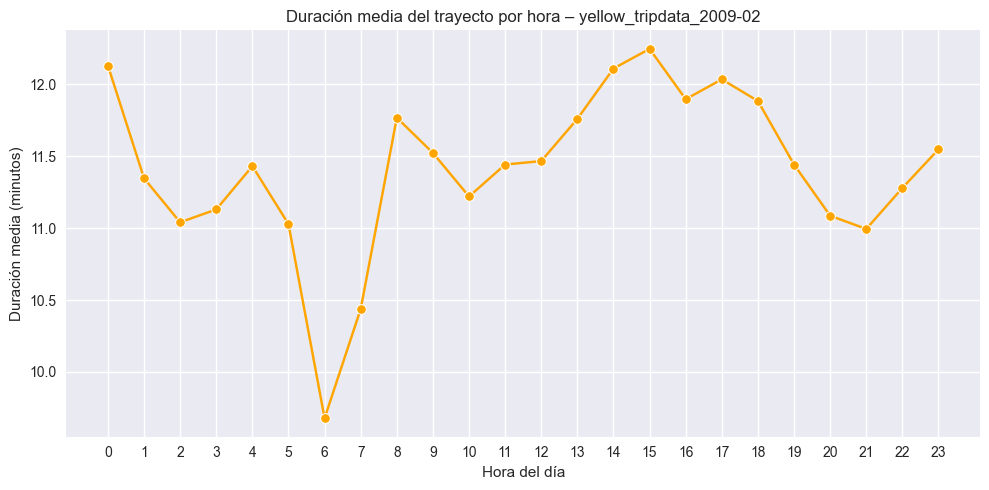

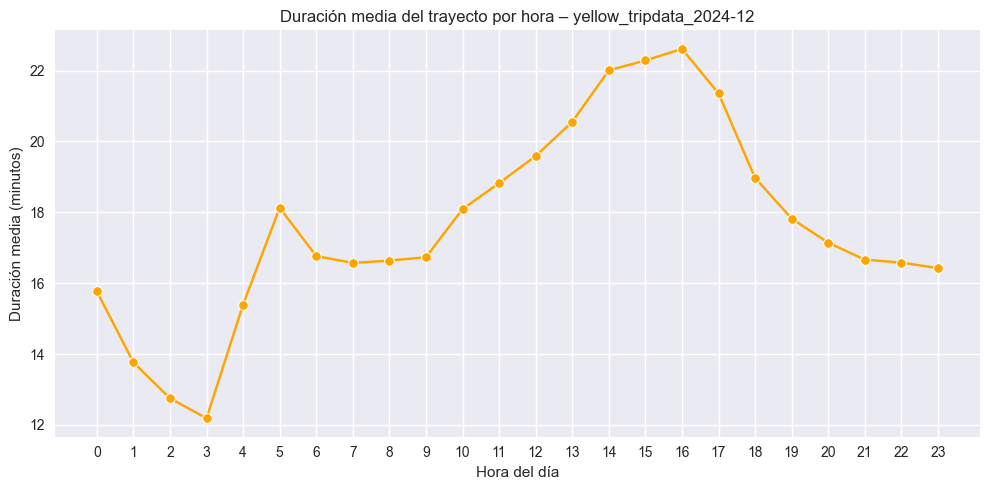

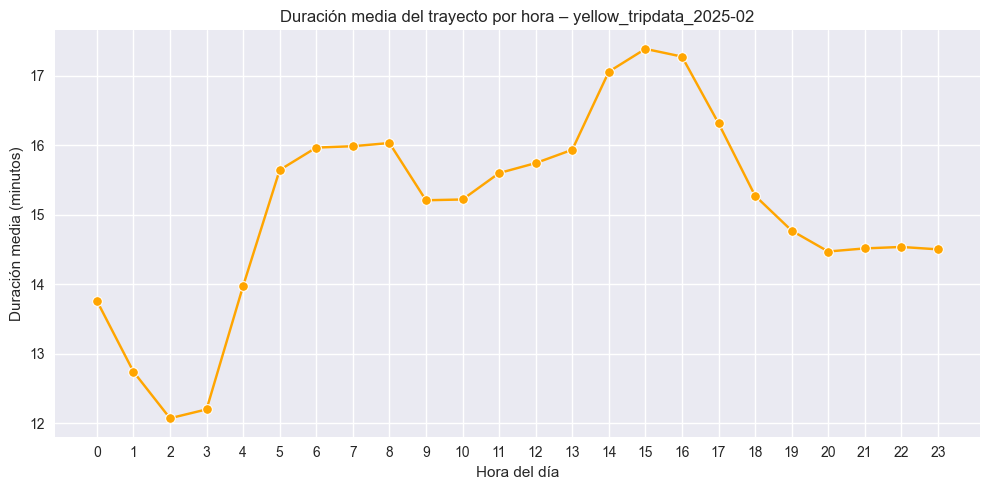

In [179]:
def plot_tiempo_medio_por_hora_dict(datasets_dict):
    """
    Grafica la duración media (en minutos) del trayecto a lo largo del día para cada dataset del diccionario.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
    """
    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Verificar columnas necesarias
        if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
            df['hora'] = pd.to_datetime(df['pickup_datetime'], errors='coerce').dt.hour
            df['duracion_min'] = (
                pd.to_datetime(df['dropoff_datetime'], errors='coerce') -
                pd.to_datetime(df['pickup_datetime'], errors='coerce')
            ).dt.total_seconds() / 60
        else:
            print(f"❌ {nombre}: columnas de fecha no encontradas. Se omite.")
            continue

        df = df[df['duracion_min'] > 0]
        if df.empty:
            print(f"⚠️ {nombre}: sin datos válidos para calcular duración.")
            continue

        media_por_hora = df.groupby('hora')['duracion_min'].mean()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=media_por_hora.index, y=media_por_hora.values, marker="o", color="orange")
        plt.title(f"Duración media del trayecto por hora – {nombre}")
        plt.xlabel("Hora del día")
        plt.ylabel("Duración media (minutos)")
        plt.xticks(range(0, 24))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Generar gráficos de duración media por hora para los datasets limpios
plot_tiempo_medio_por_hora_dict(normalized_datasets)

### Muestra la evolución de la distancia media de trayecto a lo largo del día.

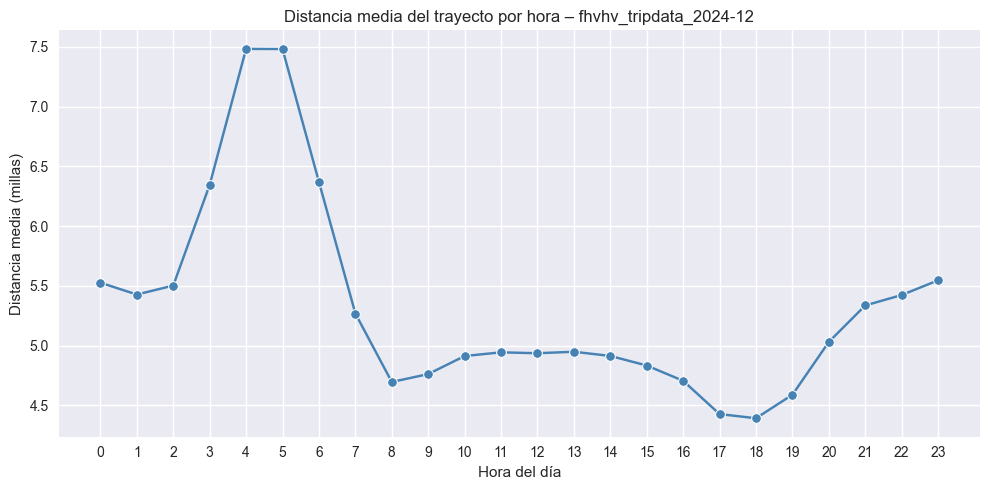

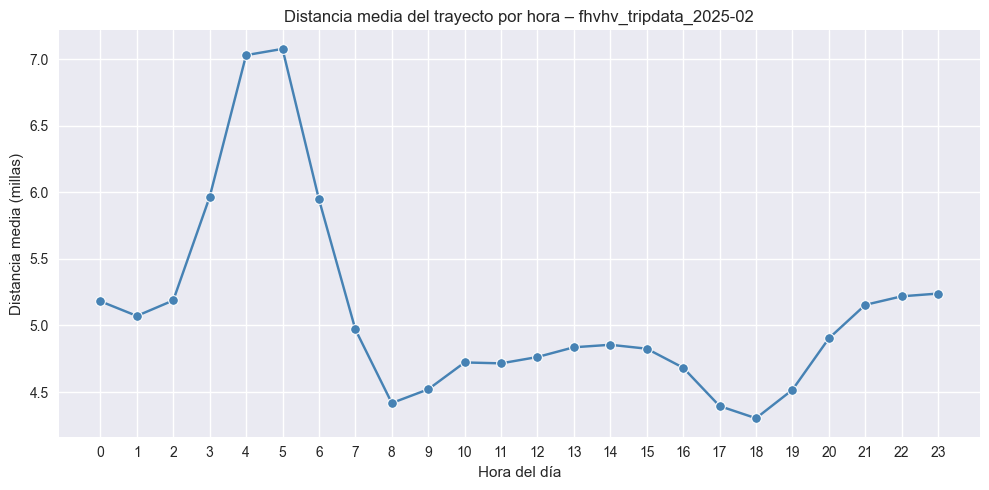

❌ fhv_tripdata_2024-12: columnas necesarias no encontradas. Se omite.
❌ fhv_tripdata_2025-02: columnas necesarias no encontradas. Se omite.


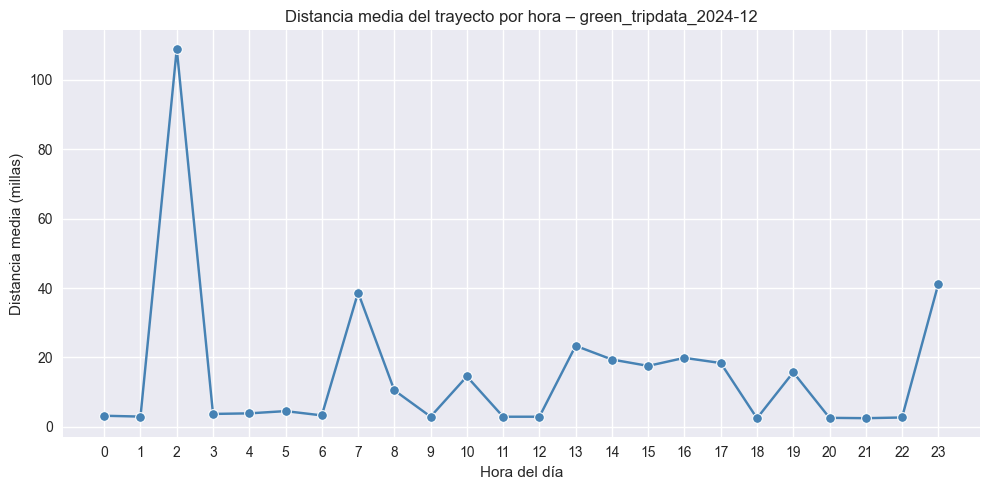

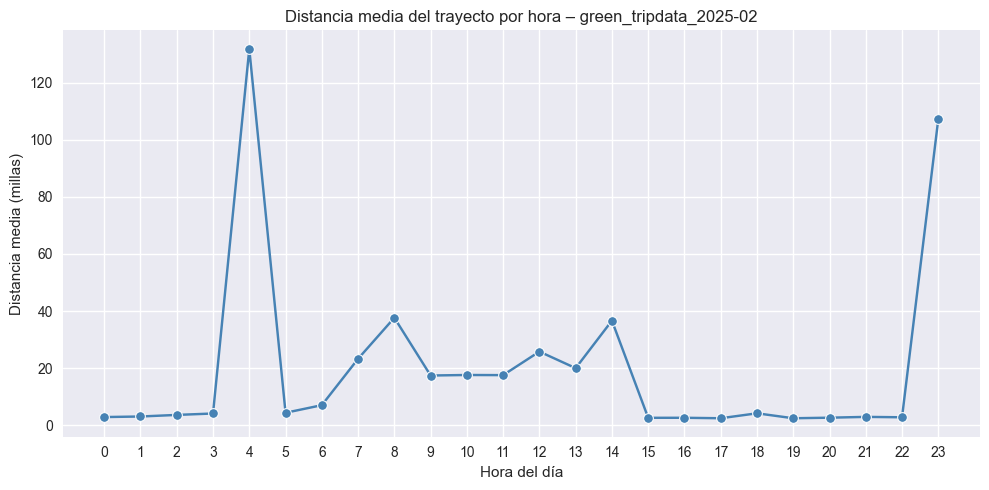

❌ yellow_tripdata_2009-02: columnas necesarias no encontradas. Se omite.


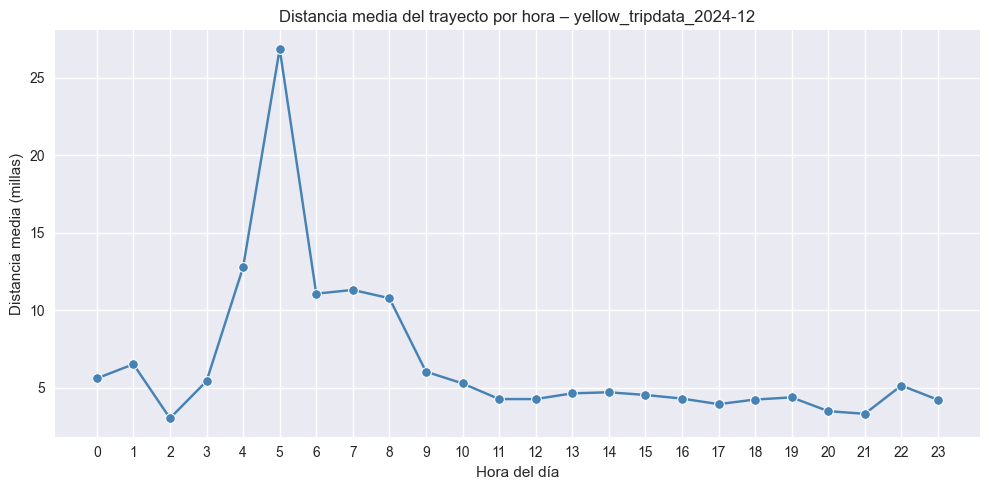

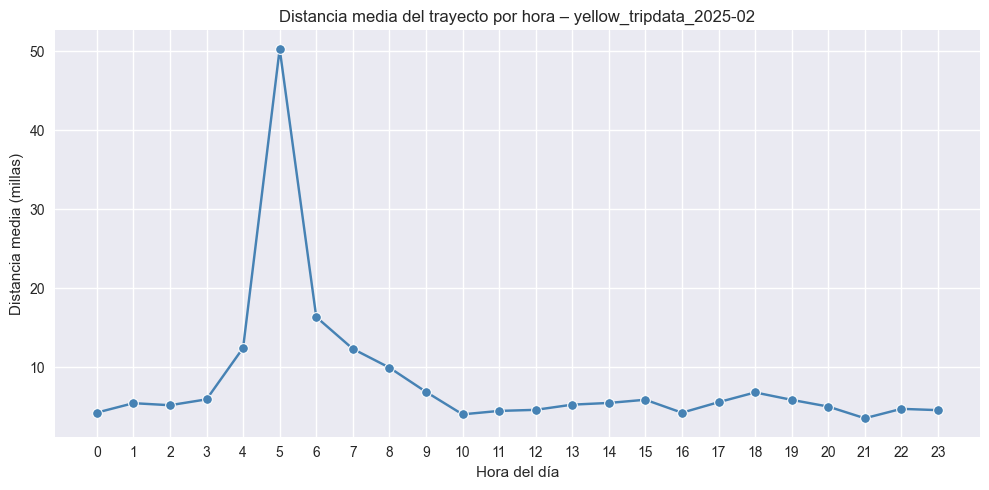

In [180]:
def plot_distancia_media_por_hora_dict(datasets_dict):
    """
    Grafica la distancia media (millas) del trayecto a lo largo del día para cada dataset del diccionario.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}
    """
    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Verificar columnas necesarias
        if 'pickup_datetime' in df.columns and 'trip_distance' in df.columns:
            df['hora'] = pd.to_datetime(df['pickup_datetime'], errors='coerce').dt.hour
        else:
            print(f"❌ {nombre}: columnas necesarias no encontradas. Se omite.")
            continue

        df = df[df['trip_distance'] > 0]
        if df.empty:
            print(f"⚠️ {nombre}: sin datos válidos para calcular distancia.")
            continue

        media_por_hora = df.groupby('hora')['trip_distance'].mean()

        # Plot
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=media_por_hora.index, y=media_por_hora.values, marker="o", color="steelblue")
        plt.title(f"Distancia media del trayecto por hora – {nombre}")
        plt.xlabel("Hora del día")
        plt.ylabel("Distancia media (millas)")
        plt.xticks(range(0, 24))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Generar gráficos de distancia media por hora para los datasets limpios
plot_distancia_media_por_hora_dict(normalized_datasets)

## 2.4	Elige dos zonas cualesquiera de la ciudad y calcula la probabilidad de desplazarse de una zona a otra en menos de X minutos. (El valor X, así como las zonas deben ser fácilmente modificables).

In [181]:
def calcular_probabilidad_desplazamiento_rapido_dict(datasets_dict, origen, destino, umbral_min=10):
    """
    Calcula la probabilidad de que un trayecto entre dos zonas específicas dure menos de X minutos
    para cada dataset del diccionario.

    Parámetros:
        - datasets_dict: diccionario {nombre_dataset: DataFrame}
        - origen: ID de la zona de origen (int)
        - destino: ID de la zona de destino (int)
        - umbral_min: duración máxima para considerar un trayecto como rápido (por defecto 10 minutos)

    Muestra resultados por consola para cada dataset.
    """
    resultados = []

    for nombre, df in datasets_dict.items():
        df = df.copy()

        if "pickup_datetime" not in df.columns or "dropoff_datetime" not in df.columns:
            print(f"❌ {nombre}: columnas de fecha no encontradas. Se omite.")
            continue

        if "PULocationID" not in df.columns or "DOLocationID" not in df.columns:
            print(f"❌ {nombre}: columnas de zona no encontradas. Se omite.")
            continue

        # Calcular duración en minutos
        pickup = pd.to_datetime(df["pickup_datetime"], errors="coerce")
        dropoff = pd.to_datetime(df["dropoff_datetime"], errors="coerce")
        df["duracion_min"] = (dropoff - pickup).dt.total_seconds() / 60

        # Filtrar trayectos válidos
        trayectos = df[
            (df["PULocationID"] == origen) &
            (df["DOLocationID"] == destino) &
            (df["duracion_min"].notnull())
        ]

        total = len(trayectos)
        if total == 0:
            print(f"⚠️ {nombre}: sin trayectos entre {origen} → {destino}.")
            continue

        rapidos = trayectos[trayectos["duracion_min"] < umbral_min]
        probabilidad = len(rapidos) / total

        print(f"📊 {nombre}:")
        print(f"- Total trayectos {origen} → {destino}: {total}")
        print(f"- < {umbral_min} min: {len(rapidos)} ({probabilidad:.2%})")

        resultados.append({
            "Dataset": nombre,
            "Trayectos": total,
            "Rápidos (< X min)": len(rapidos),
            "Probabilidad (%)": round(probabilidad * 100, 2)
        })

    return pd.DataFrame(resultados)


# Ejemplo: ¿Qué probabilidad hay de ir de Midtown Center (161) a West Chelsea (246) en menos de 8 minutos?
calcular_probabilidad_desplazamiento_rapido_dict(
    normalized_datasets,
   origen=161,
    destino=246,
    umbral_min=8
)

📊 fhvhv_tripdata_2024-12:
- Total trayectos 161 → 246: 5655
- < 8 min: 47 (0.83%)
📊 fhvhv_tripdata_2025-02:
- Total trayectos 161 → 246: 5861
- < 8 min: 80 (1.36%)
📊 fhv_tripdata_2024-12:
- Total trayectos 161 → 246: 7
- < 8 min: 0 (0.00%)
📊 fhv_tripdata_2025-02:
- Total trayectos 161 → 246: 60
- < 8 min: 0 (0.00%)
⚠️ green_tripdata_2024-12: sin trayectos entre 161 → 246.
⚠️ green_tripdata_2025-02: sin trayectos entre 161 → 246.
❌ yellow_tripdata_2009-02: columnas de zona no encontradas. Se omite.
📊 yellow_tripdata_2024-12:
- Total trayectos 161 → 246: 3080
- < 8 min: 28 (0.91%)
📊 yellow_tripdata_2025-02:
- Total trayectos 161 → 246: 3522
- < 8 min: 82 (2.33%)


,Dataset,Trayectos,Rápidos (< X min),Probabilidad (%)
0,fhvhv_tripdata_2024-12,5655,47,0.83
1,fhvhv_tripdata_2025-02,5861,80,1.36
2,fhv_tripdata_2024-12,7,0,0.00
3,fhv_tripdata_2025-02,60,0,0.00
4,yellow_tripdata_2024-12,3080,28,0.91
5,yellow_tripdata_2025-02,3522,82,2.33


## 2.5	Repite los apartados 1.1, 1.2, 1.3, 1.4, 2.1, 2.2, 2.3 y 2.4 con un dataset del mismo mes, pero del año 2009. Comenta todas las diferencias que vayas encontrando.


Febrero de 2009
Se realizará en las funciones anteriores, añadiendo el nuevo DataSet yellow_tripdata_2009-02

# Tercera Parte: Análisis Predictivo

## 3.1	¿Cuáles son las zonas donde es más probable coger un taxi en función de la hora del día?


## 3.2	¿Cuál es la mejor hora del día para ir al aeropuerto?

## 3.3	Diseña un modelo que, dada una hora, una zona origen, y una zona destino, predice la duración del trayecto y su coste. Muestra la relevancia de los atributos del dataset.